# Hyperparameters Tunning for Deep Learning Models (full of errors)
TODO add description

In [1]:
import optuna 
import sys; sys.path.append('..')
from thesis_package import utils, aimodels as myai, metrics

from copy import deepcopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
num_trials = 30

c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Regression
y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
train_x, valid_x, train_y, valid_y, scaler_max = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
data_max_reg = {'X_train': deepcopy(train_x), 'X_test': deepcopy(valid_x), 'y_train': deepcopy(train_y), 'y_test': deepcopy(valid_y)}
y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler_min = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
data_min_reg = {'X_train': deepcopy(train_x), 'X_test': deepcopy(valid_x), 'y_train': deepcopy(train_y), 'y_test': deepcopy(valid_y)}
# Threshold
threshold_max = utils.compute_threshold(y_max_u) / scaler_max['y']
threshold_min = utils.compute_threshold(y_min_u) / scaler_min['y']
print(threshold_min)
print(threshold_max)
# Classification
y_max_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_sparse_bool[utils.cols_with_positive_values(y_max_u_sparse_bool)], test_size=0.2, scaling=True)
data_max_class = {'X_train': deepcopy(train_x), 'X_test': deepcopy(valid_x), 'y_train': deepcopy(train_y), 'y_test': deepcopy(valid_y)}

y_min_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_sparse_bool[utils.cols_with_positive_values(y_min_u_sparse_bool)], test_size=0.2, scaling=True)
data_min_class = {'X_train': deepcopy(train_x), 'X_test': deepcopy(valid_x), 'y_train': deepcopy(train_y), 'y_test': deepcopy(valid_y)}

0.0644069763149719
0.05260425830867303


# Max u

## MLP: Sparse Classification Dataset

Build optuna study...

[I 2022-10-14 18:56:58,546] A new study created in memory with name: no-name-3a8cfc46-147e-4817-815c-2cd2cc64f224
[I 2022-10-14 18:57:28,731] Trial 0 finished with value: 0.1223393466358087 and parameters: {'hidden_size': 92, 'n_layers': 1, 'dropout': 0.04675443086912656, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.0048693311089522675, 'epochs': 10, 'batch_size': 16}. Best is trial 0 with value: 0.1223393466358087.
[I 2022-10-14 19:00:32,035] Trial 1 finished with value: 0.13542706000164628 and parameters: {'hidden_size': 68, 'n_layers': 1, 'dropout': 0.03548157652256295, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.020997357143309373, 'epochs': 67, 'batch_size': 1024}. Best is trial 1 with value: 0.13542706000164628.
[I 2022-10-14 19:09:02,159] Trial 2 finished with value: 0.11721758431823065 and parameters: {'hidden_size': 60, 'n_layers': 2, 'dropout': 0.30336498394099837, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.09724466228636645, 'epochs': 94, 'batch_size': 4}.

Number of finished trials:  30
Best trial:
  Value: 0.1573007564672189
  Params: 
    hidden_size: 43
    n_layers: 1
    dropout: 0.14458911416129674
    activation: relu
    optimizer: sgd
    lr: 0.04809535841376039
    epochs: 99
    batch_size: 128


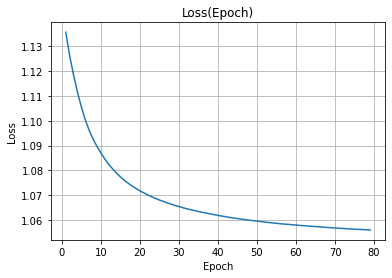

In [3]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns='timestamps') 
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_max_u_bool_train, X_max_u_bool_test, y_max_u_bool_train, y_max_u_bool_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u_bool[utils.cols_with_positive_values(y_max_u_bool)], test_size=0.2, scaling=True)
    data = {'X_train':X_max_u_bool_train.astype(float),
            'X_test': X_max_u_bool_test.astype(float),
            'y_train':y_max_u_bool_train.astype(float),
            'y_test': y_max_u_bool_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': True
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_max_class)
    prediction = pd.DataFrame(prediction, columns=utils.cols_with_positive_values(y_max_u_bool))
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (data_max_class['y_test'][bus] == 1))
        tn += sum((prediction[bus] == 0) & (data_max_class['y_test'][bus] == 0))
        fp += sum((prediction[bus] == 1) & (data_max_class['y_test'][bus] == 0))
        fn += sum((prediction[bus] == 0) & (data_max_class['y_test'][bus] == 1))
    mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_sparse_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,True\n")
    f.write("value,{}\n".format(trial.value))

Now we confirm that the target feature is created correctly, being in accord with the sparse dataset.

## MLP: Balanced Classification Dataset

[I 2022-10-14 20:36:07,667] A new study created in memory with name: no-name-461ecc86-0295-4012-8111-f6cf120461a8
[I 2022-10-14 20:36:35,996] Trial 0 finished with value: 0.1680857704170967 and parameters: {'hidden_size': 31, 'n_layers': 2, 'dropout': 0.16489612204817944, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.0024709656826210568, 'epochs': 57, 'batch_size': 8}. Best is trial 0 with value: 0.1680857704170967.
[I 2022-10-14 20:37:59,914] Trial 1 finished with value: 0.14790184903321105 and parameters: {'hidden_size': 87, 'n_layers': 3, 'dropout': 0.4132928870306444, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.006744818308560079, 'epochs': 89, 'batch_size': 32}. Best is trial 0 with value: 0.1680857704170967.
[I 2022-10-14 20:38:05,863] Trial 2 finished with value: 0.11777960165935197 and parameters: {'hidden_size': 36, 'n_layers': 1, 'dropout': 0.22667671935034184, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.00020395131885743157, 'epochs': 15, 'batch_size': 

Number of finished trials:  30
Best trial:
  Value: 0.2207909541962127
  Params: 
    hidden_size: 71
    n_layers: 3
    dropout: 0.17394342303817398
    activation: tanh
    optimizer: adam
    lr: 0.00045119770029163666
    epochs: 65
    batch_size: 64


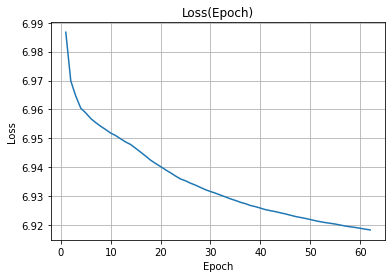

In [4]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_bool_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv').drop(columns=['date'])
    X_max_u_bool_train, X_max_u_bool_test, y_max_u_bool_train, y_max_u_bool_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u_bool[utils.cols_with_positive_values(y_max_u_bool)], test_size=0.2, scaling=True)
    data = {'X_train':X_max_u_bool_train.astype(float),
            'X_test': X_max_u_bool_test.astype(float),
            'y_train':y_max_u_bool_train.astype(float),
            'y_test': y_max_u_bool_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': True
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_max_class)
    prediction = pd.DataFrame(prediction, columns=utils.cols_with_positive_values(y_max_u_bool))
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (data_max_class['y_test'][bus] == 1))
        tn += sum((prediction[bus] == 0) & (data_max_class['y_test'][bus] == 0))
        fp += sum((prediction[bus] == 1) & (data_max_class['y_test'][bus] == 0))
        fn += sum((prediction[bus] == 0) & (data_max_class['y_test'][bus] == 1))
    mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_balanced_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,True\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Sparse Dataset

[I 2022-10-14 20:59:58,980] A new study created in memory with name: no-name-d1b2fd23-d861-4afc-b66e-999a1a5045f3
[I 2022-10-14 21:03:43,922] Trial 0 finished with value: 0.06707833241179745 and parameters: {'hidden_size': 26, 'n_layers': 2, 'dropout': 0.4732847769701089, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.0006034213118226314, 'epochs': 76, 'batch_size': 16}. Best is trial 0 with value: 0.06707833241179745.


true_positives_ctr:  4903
true_negatives_ctr:  211970
false_positives_ctr:  90577
false_negatives_ctr:  46
30310377944761031040


[I 2022-10-14 21:06:01,301] Trial 1 finished with value: 0.07403477383238384 and parameters: {'hidden_size': 91, 'n_layers': 1, 'dropout': 0.4842524738407927, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.006321145983273893, 'epochs': 47, 'batch_size': 1}. Best is trial 1 with value: 0.07403477383238384.


true_positives_ctr:  4935
true_negatives_ctr:  226057
false_positives_ctr:  76490
false_negatives_ctr:  14
27562139553489986025


[I 2022-10-14 21:10:54,643] Trial 2 finished with value: 0.07997069077053633 and parameters: {'hidden_size': 36, 'n_layers': 2, 'dropout': 0.42780442525994883, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.036648790742046335, 'epochs': 72, 'batch_size': 128}. Best is trial 2 with value: 0.07997069077053633.


true_positives_ctr:  4726
true_negatives_ctr:  234926
false_positives_ctr:  67621
false_negatives_ctr:  223
25472640591694859409


[I 2022-10-14 21:11:36,759] Trial 3 finished with value: 0.07440183292072547 and parameters: {'hidden_size': 13, 'n_layers': 1, 'dropout': 0.45022226421029865, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0013036466213983428, 'epochs': 2, 'batch_size': 256}. Best is trial 2 with value: 0.07997069077053633.


true_positives_ctr:  4931
true_negatives_ctr:  226179
false_positives_ctr:  76368
false_negatives_ctr:  18
27534826803839175009


[I 2022-10-14 21:13:33,702] Trial 4 finished with value: 0.07473360723160918 and parameters: {'hidden_size': 84, 'n_layers': 2, 'dropout': 0.35668665497615587, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.0012490473820303835, 'epochs': 31, 'batch_size': 1}. Best is trial 2 with value: 0.07997069077053633.


true_positives_ctr:  4935
true_negatives_ctr:  225855
false_positives_ctr:  76692
false_negatives_ctr:  14
27605827454626127889


[I 2022-10-14 21:15:57,148] Trial 5 finished with value: 0.07437474775682378 and parameters: {'hidden_size': 45, 'n_layers': 3, 'dropout': 0.20764309379578533, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.0005022697632223084, 'epochs': 37, 'batch_size': 512}. Best is trial 2 with value: 0.07997069077053633.


true_positives_ctr:  4722
true_negatives_ctr:  233853
false_positives_ctr:  68694
false_negatives_ctr:  227
25731513529507779840


[I 2022-10-14 21:19:13,483] Trial 6 finished with value: 0.09634765500766988 and parameters: {'hidden_size': 95, 'n_layers': 1, 'dropout': 0.04733174259038525, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 4.862517944401841e-05, 'epochs': 74, 'batch_size': 128}. Best is trial 6 with value: 0.09634765500766988.


true_positives_ctr:  4415
true_negatives_ctr:  211396
false_positives_ctr:  91151
false_negatives_ctr:  534
30325373006176045140


[I 2022-10-14 21:20:05,324] Trial 7 finished with value: 0.09724556590126697 and parameters: {'hidden_size': 58, 'n_layers': 3, 'dropout': 0.13495181239726772, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.0007557884880935418, 'epochs': 5, 'batch_size': 128}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  4377
true_negatives_ctr:  194370
false_positives_ctr:  108177
false_negatives_ctr:  572
32853122714440432404


[I 2022-10-14 21:21:30,332] Trial 8 finished with value: 0.06864272000868327 and parameters: {'hidden_size': 84, 'n_layers': 3, 'dropout': 0.44388030807742374, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.0467616314033606, 'epochs': 14, 'batch_size': 4}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  4948
true_negatives_ctr:  216944
false_positives_ctr:  85603
false_negatives_ctr:  1
29413939904749404585


[I 2022-10-14 21:32:37,653] Trial 9 finished with value: 0.08131036183803564 and parameters: {'hidden_size': 83, 'n_layers': 3, 'dropout': 0.2958068707294496, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.00010760682172558219, 'epochs': 100, 'batch_size': 8}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  4894
true_negatives_ctr:  230825
false_positives_ctr:  71722
false_negatives_ctr:  55
26485982811871914240


[I 2022-10-14 21:33:57,179] Trial 10 finished with value: -0.08357290821756623 and parameters: {'hidden_size': 62, 'n_layers': 3, 'dropout': 0.11134147980651765, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 1.0090758738424887e-05, 'epochs': 14, 'batch_size': 2}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  781
true_negatives_ctr:  195997
false_positives_ctr:  106550
false_negatives_ctr:  4168
32167967498930265345


[I 2022-10-14 21:36:44,162] Trial 11 finished with value: 0.06776853607004661 and parameters: {'hidden_size': 62, 'n_layers': 1, 'dropout': 0.017280013246009154, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 5.624446132911661e-05, 'epochs': 66, 'batch_size': 128}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  4233
true_negatives_ctr:  205271
false_positives_ctr:  97276
false_negatives_ctr:  716
31307952533019856449


[I 2022-10-14 21:40:22,971] Trial 12 finished with value: 0.08761950505820168 and parameters: {'hidden_size': 64, 'n_layers': 1, 'dropout': 0.11939161882537053, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 6.340434210667199e-05, 'epochs': 92, 'batch_size': 1024}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  4698
true_negatives_ctr:  203149
false_positives_ctr:  99398
false_negatives_ctr:  251
31702630205184019200


[I 2022-10-14 21:42:38,641] Trial 13 finished with value: -0.00628166431822833 and parameters: {'hidden_size': 1, 'n_layers': 2, 'dropout': 0.00822955881005108, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 1.4756645890731574e-05, 'epochs': 57, 'batch_size': 32}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  3579
true_negatives_ctr:  143851
false_positives_ctr:  158696
false_negatives_ctr:  1370
35285099426467365825


[I 2022-10-14 21:46:55,254] Trial 14 finished with value: 0.0714906553761772 and parameters: {'hidden_size': 99, 'n_layers': 2, 'dropout': 0.11119874005354756, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.006718885947757906, 'epochs': 84, 'batch_size': 64}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  4946
true_negatives_ctr:  219979
false_positives_ctr:  82568
false_negatives_ctr:  3
28825376299609129044


[I 2022-10-14 21:50:05,627] Trial 15 finished with value: 0.08269724250794007 and parameters: {'hidden_size': 73, 'n_layers': 1, 'dropout': 0.20102521017748087, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0001905656894722354, 'epochs': 59, 'batch_size': 128}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  4723
true_negatives_ctr:  243182
false_positives_ctr:  59365
false_negatives_ctr:  226
23357258724270506112


[I 2022-10-14 21:52:34,804] Trial 16 finished with value: 0.07405331429933121 and parameters: {'hidden_size': 48, 'n_layers': 3, 'dropout': 0.06097775921611774, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.004840166189433709, 'epochs': 43, 'batch_size': 128}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  4935
true_negatives_ctr:  226086
false_positives_ctr:  76461
false_negatives_ctr:  14
27555857497632466800


[I 2022-10-14 21:54:05,944] Trial 17 finished with value: 0.0267904751918936 and parameters: {'hidden_size': 99, 'n_layers': 2, 'dropout': 0.17530501660334177, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 2.7791553990064836e-05, 'epochs': 22, 'batch_size': 128}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  3238
true_negatives_ctr:  189952
false_positives_ctr:  112595
false_negatives_ctr:  1711
33241521278940823737


[I 2022-10-14 21:54:45,455] Trial 18 finished with value: 0.07647969027148985 and parameters: {'hidden_size': 31, 'n_layers': 2, 'dropout': 0.2740064674236046, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.00023604405657615398, 'epochs': 1, 'batch_size': 4}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  4928
true_negatives_ctr:  226368
false_positives_ctr:  76179
false_negatives_ctr:  21
27493115956339475169


[I 2022-10-14 21:58:03,392] Trial 19 finished with value: 0.07405331429933121 and parameters: {'hidden_size': 70, 'n_layers': 1, 'dropout': 0.05563949832071658, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.0028716921779878934, 'epochs': 81, 'batch_size': 64}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  4935
true_negatives_ctr:  226086
false_positives_ctr:  76461
false_negatives_ctr:  14
27555857497632466800


[I 2022-10-14 22:01:19,577] Trial 20 finished with value: 0.08847918310246845 and parameters: {'hidden_size': 54, 'n_layers': 3, 'dropout': 0.14053763875331443, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.0002508754516131598, 'epochs': 57, 'batch_size': 1024}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  4890
true_negatives_ctr:  221932
false_positives_ctr:  80615
false_negatives_ctr:  59
28420857925051841865


[I 2022-10-14 22:04:40,439] Trial 21 finished with value: 0.0961916404716416 and parameters: {'hidden_size': 54, 'n_layers': 3, 'dropout': 0.14740660183935028, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.00023611234327483292, 'epochs': 58, 'batch_size': 1024}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  4704
true_negatives_ctr:  225247
false_positives_ctr:  77300
false_negatives_ctr:  245
27687036948714574704


[I 2022-10-14 22:08:22,626] Trial 22 finished with value: 0.03320756383818689 and parameters: {'hidden_size': 41, 'n_layers': 3, 'dropout': 0.05147816581001405, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 3.998042815315261e-05, 'epochs': 67, 'batch_size': 1024}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  3171
true_negatives_ctr:  201938
false_positives_ctr:  100609
false_negatives_ctr:  1778
31655495160325987440


[I 2022-10-14 22:11:21,052] Trial 23 finished with value: 0.09286871675015561 and parameters: {'hidden_size': 54, 'n_layers': 3, 'dropout': 0.15893981096957527, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.00012482186197364318, 'epochs': 51, 'batch_size': 8}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  3687
true_negatives_ctr:  228997
false_positives_ctr:  73550
false_negatives_ctr:  1262
26628844140042796449


[I 2022-10-14 22:13:13,366] Trial 24 finished with value: 0.062089443524901464 and parameters: {'hidden_size': 24, 'n_layers': 3, 'dropout': 0.2421078032967649, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.00048703717754067943, 'epochs': 33, 'batch_size': 2}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  4426
true_negatives_ctr:  222630
false_positives_ctr:  79917
false_negatives_ctr:  523
28181368501677623337


[I 2022-10-14 22:17:01,552] Trial 25 finished with value: 0.00029249027407918064 and parameters: {'hidden_size': 70, 'n_layers': 3, 'dropout': 0.0692106069470131, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 2.1671374981661248e-05, 'epochs': 65, 'batch_size': 16}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  2258
true_negatives_ctr:  216270
false_positives_ctr:  86277
false_negatives_ctr:  2691
29026325705024524905


[I 2022-10-14 22:26:53,649] Trial 26 finished with value: 0.0576388597858106 and parameters: {'hidden_size': 55, 'n_layers': 2, 'dropout': 0.09761260469867417, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.02045153920547751, 'epochs': 85, 'batch_size': 32}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  4013
true_negatives_ctr:  251836
false_positives_ctr:  50711
false_negatives_ctr:  936
20711764703936617584


[I 2022-10-14 22:30:34,835] Trial 27 finished with value: 0.0745086017899888 and parameters: {'hidden_size': 76, 'n_layers': 3, 'dropout': 0.1899773062553784, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.0018726990925352059, 'epochs': 22, 'batch_size': 256}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  4935
true_negatives_ctr:  226085
false_positives_ctr:  76462
false_negatives_ctr:  14
27556074162172786209


[I 2022-10-14 22:33:47,813] Trial 28 finished with value: 0.04597121988901439 and parameters: {'hidden_size': 15, 'n_layers': 1, 'dropout': 0.3218879148363317, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.0001159459999983097, 'epochs': 75, 'batch_size': 512}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  3966
true_negatives_ctr:  188532
false_positives_ctr:  114015
false_negatives_ctr:  983
33478498164460004145


[I 2022-10-14 22:37:10,681] Trial 29 finished with value: 0.07736827812292595 and parameters: {'hidden_size': 40, 'n_layers': 2, 'dropout': 0.25151111787825486, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.0009064606449171225, 'epochs': 44, 'batch_size': 16}. Best is trial 7 with value: 0.09724556590126697.


true_positives_ctr:  4929
true_negatives_ctr:  226175
false_positives_ctr:  76372
false_negatives_ctr:  20
27535260710879583585
Number of finished trials:  30
Best trial:
  Value: 0.09724556590126697
  Params: 
    hidden_size: 58
    n_layers: 3
    dropout: 0.13495181239726772
    activation: tanh
    optimizer: sgd
    lr: 0.0007557884880935418
    epochs: 5
    batch_size: 128


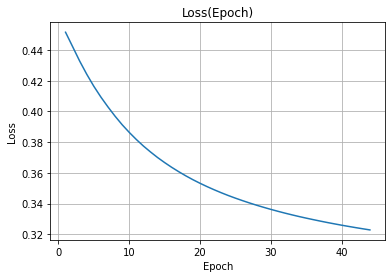

In [5]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns='timestamps')
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train':X_max_u_train.astype(float),
            'X_test': X_max_u_test.astype(float),
            'y_train':y_max_u_train.astype(float),
            'y_test': y_max_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_max_reg)
    prediction = pd.DataFrame(prediction, columns=y_max_u.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_max_reg['y_test'], threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_sparse_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Focused Dataset

[I 2022-10-14 22:37:10,988] A new study created in memory with name: no-name-cda87e48-b2a9-4aac-b68d-d19ab3c360ae
[I 2022-10-14 22:38:05,458] Trial 0 finished with value: 0.07404021804061559 and parameters: {'hidden_size': 21, 'n_layers': 3, 'dropout': 0.4763897237366296, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.002527088279708634, 'epochs': 46, 'batch_size': 16}. Best is trial 0 with value: 0.07404021804061559.


true_positives_ctr:  4935
true_negatives_ctr:  226011
false_positives_ctr:  76536
false_negatives_ctr:  14
27572099028113100825


[I 2022-10-14 22:39:00,810] Trial 1 finished with value: 0.07405331516274469 and parameters: {'hidden_size': 70, 'n_layers': 2, 'dropout': 0.05231606220438062, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.0019733366539544106, 'epochs': 29, 'batch_size': 32}. Best is trial 1 with value: 0.07405331516274469.


true_positives_ctr:  4935
true_negatives_ctr:  226086
false_positives_ctr:  76461
false_negatives_ctr:  14
27555857497632466800


[I 2022-10-14 22:39:45,290] Trial 2 finished with value: 0.07406765884187906 and parameters: {'hidden_size': 50, 'n_layers': 1, 'dropout': 0.4502261552304055, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.00907242804716114, 'epochs': 1, 'batch_size': 2}. Best is trial 2 with value: 0.07406765884187906.


true_positives_ctr:  4935
true_negatives_ctr:  226086
false_positives_ctr:  76461
false_negatives_ctr:  14
27555857497632466800


[I 2022-10-14 22:40:40,971] Trial 3 finished with value: -0.05266810151245851 and parameters: {'hidden_size': 43, 'n_layers': 3, 'dropout': 0.17584347724510435, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 3.0396203731245475e-05, 'epochs': 67, 'batch_size': 1}. Best is trial 2 with value: 0.07406765884187906.


true_positives_ctr:  1804
true_negatives_ctr:  198324
false_positives_ctr:  104223
false_negatives_ctr:  3145
31984164385577042289


[I 2022-10-14 22:41:27,775] Trial 4 finished with value: 0.06870964776325818 and parameters: {'hidden_size': 64, 'n_layers': 1, 'dropout': 0.22428589816515465, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.05110232872611822, 'epochs': 38, 'batch_size': 512}. Best is trial 2 with value: 0.07406765884187906.


true_positives_ctr:  4948
true_negatives_ctr:  217056
false_positives_ctr:  85491
false_negatives_ctr:  1
29392725079861071369


[I 2022-10-14 22:42:39,556] Trial 5 finished with value: 0.05617944362041236 and parameters: {'hidden_size': 64, 'n_layers': 3, 'dropout': 0.007760848937307829, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 8.950126184876245e-05, 'epochs': 95, 'batch_size': 1024}. Best is trial 2 with value: 0.07406765884187906.


true_positives_ctr:  4329
true_negatives_ctr:  227841
false_positives_ctr:  74706
false_negatives_ctr:  620
27035962523521933905


[I 2022-10-14 22:43:33,695] Trial 6 finished with value: 0.07405217177005533 and parameters: {'hidden_size': 55, 'n_layers': 1, 'dropout': 0.08697346231531194, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.0032039273419923677, 'epochs': 70, 'batch_size': 128}. Best is trial 2 with value: 0.07406765884187906.


true_positives_ctr:  4935
true_negatives_ctr:  226084
false_positives_ctr:  76463
false_negatives_ctr:  14
27556290823718495412


[I 2022-10-14 22:44:47,976] Trial 7 finished with value: 0.07405834451602551 and parameters: {'hidden_size': 98, 'n_layers': 3, 'dropout': 0.306772682059274, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 6.019760759394195e-05, 'epochs': 83, 'batch_size': 512}. Best is trial 2 with value: 0.07406765884187906.


true_positives_ctr:  4935
true_negatives_ctr:  226086
false_positives_ctr:  76461
false_negatives_ctr:  14
27555857497632466800


[I 2022-10-14 22:45:39,991] Trial 8 finished with value: 0.07580988956436094 and parameters: {'hidden_size': 24, 'n_layers': 3, 'dropout': 0.4377394323824298, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 1.2942663712699193e-05, 'epochs': 52, 'batch_size': 1}. Best is trial 8 with value: 0.07580988956436094.


true_positives_ctr:  4564
true_negatives_ctr:  235859
false_positives_ctr:  66688
false_negatives_ctr:  385
25203923414854161264


[I 2022-10-14 22:46:29,803] Trial 9 finished with value: 0.0758463710191386 and parameters: {'hidden_size': 32, 'n_layers': 2, 'dropout': 0.253497466702428, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.0010938624273752564, 'epochs': 60, 'batch_size': 1}. Best is trial 9 with value: 0.0758463710191386.


true_positives_ctr:  4935
true_negatives_ctr:  226060
false_positives_ctr:  76487
false_negatives_ctr:  14
27561489802432454484


[I 2022-10-14 22:47:10,373] Trial 10 finished with value: -0.0772852136595541 and parameters: {'hidden_size': 1, 'n_layers': 2, 'dropout': 0.327170705043973, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.00016480909156059073, 'epochs': 9, 'batch_size': 8}. Best is trial 9 with value: 0.0758463710191386.


true_positives_ctr:  2660
true_negatives_ctr:  133454
false_positives_ctr:  169093
false_negatives_ctr:  2289
34908571669013645337


[I 2022-10-14 22:48:06,399] Trial 11 finished with value: 0.07405359908230712 and parameters: {'hidden_size': 27, 'n_layers': 2, 'dropout': 0.3793022137103489, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.0004302454675076422, 'epochs': 60, 'batch_size': 1}. Best is trial 9 with value: 0.0758463710191386.


true_positives_ctr:  4935
true_negatives_ctr:  226086
false_positives_ctr:  76461
false_negatives_ctr:  14
27555857497632466800


[I 2022-10-14 22:48:49,843] Trial 12 finished with value: 0.03405205464874127 and parameters: {'hidden_size': 28, 'n_layers': 2, 'dropout': 0.15778930816052733, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 1.139264476284716e-05, 'epochs': 25, 'batch_size': 64}. Best is trial 9 with value: 0.0758463710191386.


true_positives_ctr:  3249
true_negatives_ctr:  229607
false_positives_ctr:  72940
false_negatives_ctr:  1700
26387081232557064369


[I 2022-10-14 22:49:35,771] Trial 13 finished with value: 0.07447965401015597 and parameters: {'hidden_size': 7, 'n_layers': 2, 'dropout': 0.39116417881107024, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.000440377601787922, 'epochs': 52, 'batch_size': 4}. Best is trial 9 with value: 0.0758463710191386.


true_positives_ctr:  4933
true_negatives_ctr:  226169
false_positives_ctr:  76378
false_negatives_ctr:  16
27537430066405014105


[I 2022-10-14 22:50:36,758] Trial 14 finished with value: 0.061462696989844426 and parameters: {'hidden_size': 39, 'n_layers': 3, 'dropout': 0.27291888963263117, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.013509690605326715, 'epochs': 79, 'batch_size': 256}. Best is trial 9 with value: 0.0758463710191386.


true_positives_ctr:  4561
true_negatives_ctr:  233469
false_positives_ctr:  69078
false_negatives_ctr:  388
25785084625058564169


[I 2022-10-14 22:51:17,583] Trial 15 finished with value: 0.05112485943117958 and parameters: {'hidden_size': 16, 'n_layers': 2, 'dropout': 0.401401184604089, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.00036094915331020503, 'epochs': 45, 'batch_size': 1}. Best is trial 9 with value: 0.0758463710191386.


true_positives_ctr:  4279
true_negatives_ctr:  216111
false_positives_ctr:  86436
false_negatives_ctr:  670
29444936695746281745


[I 2022-10-14 22:52:10,765] Trial 16 finished with value: -0.007825303010887973 and parameters: {'hidden_size': 34, 'n_layers': 3, 'dropout': 0.2193045134131755, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 1.3080607357600951e-05, 'epochs': 57, 'batch_size': 1}. Best is trial 9 with value: 0.0758463710191386.


true_positives_ctr:  2496
true_negatives_ctr:  197830
false_positives_ctr:  104717
false_negatives_ctr:  2453
32151544553466046737


[I 2022-10-14 22:52:55,020] Trial 17 finished with value: 0.0742512663924934 and parameters: {'hidden_size': 13, 'n_layers': 1, 'dropout': 0.33666873542081677, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.000687421100555881, 'epochs': 30, 'batch_size': 1}. Best is trial 9 with value: 0.0758463710191386.


true_positives_ctr:  4935
true_negatives_ctr:  226086
false_positives_ctr:  76461
false_negatives_ctr:  14
27555857497632466800


[I 2022-10-14 22:53:53,719] Trial 18 finished with value: 0.07151225712493085 and parameters: {'hidden_size': 47, 'n_layers': 2, 'dropout': 0.4934442281689092, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.008696301396466686, 'epochs': 94, 'batch_size': 32}. Best is trial 9 with value: 0.0758463710191386.


true_positives_ctr:  4943
true_negatives_ctr:  220758
false_positives_ctr:  81789
false_negatives_ctr:  6
28669354861918874544


[I 2022-10-14 22:55:03,409] Trial 19 finished with value: 0.07844842124351405 and parameters: {'hidden_size': 82, 'n_layers': 2, 'dropout': 0.1325133938203037, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.06108771017443386, 'epochs': 73, 'batch_size': 16}. Best is trial 19 with value: 0.07844842124351405.


true_positives_ctr:  4726
true_negatives_ctr:  234921
false_positives_ctr:  67626
false_negatives_ctr:  223
25473859375589124864


[I 2022-10-14 22:56:14,905] Trial 20 finished with value: 0.07398610990227239 and parameters: {'hidden_size': 86, 'n_layers': 2, 'dropout': 0.12828879588468153, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0965950155065377, 'epochs': 78, 'batch_size': 16}. Best is trial 19 with value: 0.07844842124351405.


true_positives_ctr:  4726
true_negatives_ctr:  234921
false_positives_ctr:  67626
false_negatives_ctr:  223
25473859375589124864


[I 2022-10-14 22:57:21,817] Trial 21 finished with value: 0.07456446431064126 and parameters: {'hidden_size': 100, 'n_layers': 2, 'dropout': 0.2668694621757492, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0001519498271668036, 'epochs': 66, 'batch_size': 16}. Best is trial 19 with value: 0.07844842124351405.


true_positives_ctr:  4935
true_negatives_ctr:  226173
false_positives_ctr:  76374
false_negatives_ctr:  14
27536996219256809649


[I 2022-10-14 22:58:15,227] Trial 22 finished with value: 0.07412257217565647 and parameters: {'hidden_size': 85, 'n_layers': 2, 'dropout': 0.0891067490157551, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.001393833334291446, 'epochs': 58, 'batch_size': 1024}. Best is trial 19 with value: 0.07844842124351405.


true_positives_ctr:  4674
true_negatives_ctr:  242785
false_positives_ctr:  59762
false_negatives_ctr:  275
23450514264005658480


[I 2022-10-14 22:59:12,799] Trial 23 finished with value: 0.07696499211647007 and parameters: {'hidden_size': 32, 'n_layers': 3, 'dropout': 0.199858960545631, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.033957750240471804, 'epochs': 72, 'batch_size': 128}. Best is trial 19 with value: 0.07844842124351405.


true_positives_ctr:  4703
true_negatives_ctr:  236825
false_positives_ctr:  65722
false_negatives_ctr:  246
24998594502813068025


[I 2022-10-14 23:00:20,283] Trial 24 finished with value: 0.07284087313434821 and parameters: {'hidden_size': 37, 'n_layers': 2, 'dropout': 0.19197306186440707, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.034444002544650014, 'epochs': 88, 'batch_size': 128}. Best is trial 19 with value: 0.07844842124351405.


true_positives_ctr:  4653
true_negatives_ctr:  238259
false_positives_ctr:  64288
false_negatives_ctr:  296
24625009512873461265


[I 2022-10-14 23:01:17,552] Trial 25 finished with value: 0.06800688140007959 and parameters: {'hidden_size': 56, 'n_layers': 1, 'dropout': 0.11211901047547804, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.01998420538646665, 'epochs': 72, 'batch_size': 128}. Best is trial 19 with value: 0.07844842124351405.


true_positives_ctr:  4450
true_negatives_ctr:  246645
false_positives_ctr:  55902
false_negatives_ctr:  499
22333255932826212864


[I 2022-10-14 23:02:24,293] Trial 26 finished with value: 0.06879550603475662 and parameters: {'hidden_size': 78, 'n_layers': 2, 'dropout': 0.2196541771615525, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.005156151239668101, 'epochs': 87, 'batch_size': 2}. Best is trial 19 with value: 0.07844842124351405.


true_positives_ctr:  4948
true_negatives_ctr:  217059
false_positives_ctr:  85488
false_negatives_ctr:  1
29392156309052730480


[I 2022-10-14 23:03:28,888] Trial 27 finished with value: 0.07468247034773424 and parameters: {'hidden_size': 32, 'n_layers': 3, 'dropout': 0.14096039443091218, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0947335322026173, 'epochs': 75, 'batch_size': 256}. Best is trial 19 with value: 0.07844842124351405.


true_positives_ctr:  4726
true_negatives_ctr:  234921
false_positives_ctr:  67626
false_negatives_ctr:  223
25473859375589124864


[I 2022-10-14 23:04:28,634] Trial 28 finished with value: 0.06576930736833002 and parameters: {'hidden_size': 43, 'n_layers': 2, 'dropout': 0.2918213935304655, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.02857537880217034, 'epochs': 100, 'batch_size': 4}. Best is trial 19 with value: 0.07844842124351405.


true_positives_ctr:  4948
true_negatives_ctr:  211506
false_positives_ctr:  91041
false_negatives_ctr:  1
30398805404726593569


[I 2022-10-14 23:05:16,061] Trial 29 finished with value: 0.07876052657005027 and parameters: {'hidden_size': 21, 'n_layers': 3, 'dropout': 0.24785544540827825, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.04790104155493655, 'epochs': 45, 'batch_size': 16}. Best is trial 29 with value: 0.07876052657005027.


true_positives_ctr:  4881
true_negatives_ctr:  230342
false_positives_ctr:  72205
false_negatives_ctr:  68
26594212786146981780
Number of finished trials:  30
Best trial:
  Value: 0.07876052657005027
  Params: 
    hidden_size: 21
    n_layers: 3
    dropout: 0.24785544540827825
    activation: sigmoid
    optimizer: adam
    lr: 0.04790104155493655
    epochs: 45
    batch_size: 16


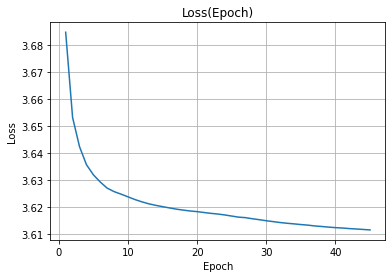

In [6]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_focused_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_focused.csv').drop(columns=['date'])
    X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u, scaling=True)
    data = {'X_train':X_max_u_train.astype(float),
            'X_test': X_max_u_test.astype(float),
            'y_train':y_max_u_train.astype(float),
            'y_test': y_max_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    # print(model.strategy.model.eval())
    prediction = model.predict(data_max_reg)
    prediction = pd.DataFrame(prediction, columns=y_max_u.columns)
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_max_reg['y_test'], threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_focused_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Filtered Dataset

[I 2022-10-14 23:05:16,350] A new study created in memory with name: no-name-5c15aaaf-e3dd-4483-a4e4-9a6b0307d31e
[I 2022-10-14 23:07:58,550] Trial 0 finished with value: 0.04346483108976869 and parameters: {'hidden_size': 45, 'n_layers': 3, 'dropout': 0.17319681506511458, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.03285539782248819, 'epochs': 48, 'batch_size': 64}. Best is trial 0 with value: 0.04346483108976869.


true_positives_ctr:  4935
true_negatives_ctr:  36211
false_positives_ctr:  76412
false_negatives_ctr:  14
1642458786670307025


[I 2022-10-14 23:15:18,652] Trial 1 finished with value: -0.005084465606432348 and parameters: {'hidden_size': 58, 'n_layers': 3, 'dropout': 0.2556495917233249, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.0016303571610690347, 'epochs': 77, 'batch_size': 128}. Best is trial 0 with value: 0.04346483108976869.


true_positives_ctr:  4055
true_negatives_ctr:  62831
false_positives_ctr:  49792
false_negatives_ctr:  894
1912563670130642025


[I 2022-10-14 23:15:37,912] Trial 2 finished with value: -0.09462401033847366 and parameters: {'hidden_size': 15, 'n_layers': 2, 'dropout': 0.30832197738378553, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 1.323810230120577e-05, 'epochs': 1, 'batch_size': 512}. Best is trial 0 with value: 0.04346483108976869.


true_positives_ctr:  2440
true_negatives_ctr:  54814
false_positives_ctr:  57809
false_negatives_ctr:  2509
1924967048239744929


[I 2022-10-14 23:18:21,461] Trial 3 finished with value: 0.010825583486082743 and parameters: {'hidden_size': 25, 'n_layers': 3, 'dropout': 0.4468184611631851, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.0009862373052636868, 'epochs': 63, 'batch_size': 1}. Best is trial 0 with value: 0.04346483108976869.


true_positives_ctr:  4315
true_negatives_ctr:  55949
false_positives_ctr:  56674
false_negatives_ctr:  634
1923454989280290249


[I 2022-10-14 23:19:52,595] Trial 4 finished with value: -0.004942164409602246 and parameters: {'hidden_size': 86, 'n_layers': 1, 'dropout': 0.23286666477605056, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.01145295271538538, 'epochs': 24, 'batch_size': 32}. Best is trial 0 with value: 0.04346483108976869.


true_positives_ctr:  4013
true_negatives_ctr:  59935
false_positives_ctr:  52688
false_negatives_ctr:  936
1923737010203212617


[I 2022-10-14 23:21:58,689] Trial 5 finished with value: 0.00948068538426689 and parameters: {'hidden_size': 70, 'n_layers': 1, 'dropout': 0.22834916784778342, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.0009739491821366645, 'epochs': 38, 'batch_size': 128}. Best is trial 0 with value: 0.04346483108976869.


true_positives_ctr:  4321
true_negatives_ctr:  56226
false_positives_ctr:  56397
false_negatives_ctr:  628
1924079571116698044


[I 2022-10-14 23:27:18,945] Trial 6 finished with value: 0.019426752320310735 and parameters: {'hidden_size': 43, 'n_layers': 2, 'dropout': 0.407341460248175, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.00028748781133874815, 'epochs': 84, 'batch_size': 4}. Best is trial 0 with value: 0.04346483108976869.


true_positives_ctr:  4426
true_negatives_ctr:  56843
false_positives_ctr:  55780
false_negatives_ctr:  523
1925036144993384892


[I 2022-10-14 23:29:35,939] Trial 7 finished with value: 0.024429037137591862 and parameters: {'hidden_size': 96, 'n_layers': 2, 'dropout': 0.4316948938928251, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.0015702324992322796, 'epochs': 34, 'batch_size': 2}. Best is trial 0 with value: 0.04346483108976869.


true_positives_ctr:  4608
true_negatives_ctr:  49324
false_positives_ctr:  63299
false_negatives_ctr:  341
1879790843943967185


[I 2022-10-14 23:33:09,547] Trial 8 finished with value: 0.00244044704436965 and parameters: {'hidden_size': 19, 'n_layers': 1, 'dropout': 0.06952073194726138, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0012309274516035809, 'epochs': 88, 'batch_size': 1}. Best is trial 0 with value: 0.04346483108976869.


true_positives_ctr:  4094
true_negatives_ctr:  64365
false_positives_ctr:  48258
false_negatives_ctr:  855
1903086890598458880


[I 2022-10-14 23:35:07,207] Trial 9 finished with value: -0.014186115686477608 and parameters: {'hidden_size': 16, 'n_layers': 1, 'dropout': 0.13674895259171754, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 1.8078859765168614e-05, 'epochs': 64, 'batch_size': 64}. Best is trial 0 with value: 0.04346483108976869.


true_positives_ctr:  3070
true_negatives_ctr:  64753
false_positives_ctr:  47870
false_negatives_ctr:  1879
1891848413894816160


[I 2022-10-14 23:36:00,031] Trial 10 finished with value: 0.026174061876129962 and parameters: {'hidden_size': 43, 'n_layers': 3, 'dropout': 0.02319051834995922, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.03171740507707031, 'epochs': 13, 'batch_size': 256}. Best is trial 0 with value: 0.04346483108976869.


true_positives_ctr:  4726
true_negatives_ctr:  44970
false_positives_ctr:  67653
false_negatives_ctr:  223
1823174742360018369


[I 2022-10-14 23:36:22,178] Trial 11 finished with value: 0.02882534653205306 and parameters: {'hidden_size': 41, 'n_layers': 3, 'dropout': 0.021504143035449147, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.09613576762053588, 'epochs': 2, 'batch_size': 256}. Best is trial 0 with value: 0.04346483108976869.


true_positives_ctr:  4726
true_negatives_ctr:  45008
false_positives_ctr:  67615
false_negatives_ctr:  223
1823749739894701017


[I 2022-10-14 23:40:28,529] Trial 12 finished with value: 0.04312565818467139 and parameters: {'hidden_size': 59, 'n_layers': 3, 'dropout': 0.12416898182460315, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.046504858776626384, 'epochs': 55, 'batch_size': 64}. Best is trial 0 with value: 0.04346483108976869.


true_positives_ctr:  4935
true_negatives_ctr:  36366
false_positives_ctr:  76257
false_negatives_ctr:  14
1646343600024805920


[I 2022-10-14 23:43:40,965] Trial 13 finished with value: 0.03160172399022961 and parameters: {'hidden_size': 59, 'n_layers': 3, 'dropout': 0.13923239431041362, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.010052697326847625, 'epochs': 52, 'batch_size': 64}. Best is trial 0 with value: 0.04346483108976869.


true_positives_ctr:  4812
true_negatives_ctr:  40337
false_positives_ctr:  72286
false_negatives_ctr:  137
1739257100421122604


[I 2022-10-14 23:47:13,485] Trial 14 finished with value: 0.044028312847211405 and parameters: {'hidden_size': 76, 'n_layers': 3, 'dropout': 0.14852027368563764, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.08627666127611071, 'epochs': 49, 'batch_size': 8}. Best is trial 14 with value: 0.044028312847211405.


true_positives_ctr:  4935
true_negatives_ctr:  37351
false_positives_ctr:  75272
false_negatives_ctr:  14
1670405090159048985


[I 2022-10-14 23:49:42,202] Trial 15 finished with value: 0.030634960108745123 and parameters: {'hidden_size': 77, 'n_layers': 2, 'dropout': 0.3457863443635942, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.008384191584233742, 'epochs': 39, 'batch_size': 8}. Best is trial 14 with value: 0.044028312847211405.


true_positives_ctr:  4759
true_negatives_ctr:  44159
false_positives_ctr:  68464
false_negatives_ctr:  190
1809988832884086729


[I 2022-10-14 23:52:18,597] Trial 16 finished with value: 0.032132912760928306 and parameters: {'hidden_size': 3, 'n_layers': 3, 'dropout': 0.18171609761938765, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.09795029803833771, 'epochs': 65, 'batch_size': 8}. Best is trial 14 with value: 0.044028312847211405.


true_positives_ctr:  4841
true_negatives_ctr:  39376
false_positives_ctr:  73247
false_negatives_ctr:  108
1718501788702068384


[I 2022-10-14 23:53:39,076] Trial 17 finished with value: 0.04189883639126428 and parameters: {'hidden_size': 71, 'n_layers': 2, 'dropout': 0.18129128923505616, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.02257903943867417, 'epochs': 24, 'batch_size': 1024}. Best is trial 14 with value: 0.044028312847211405.


true_positives_ctr:  4881
true_negatives_ctr:  41053
false_positives_ctr:  71570
false_negatives_ctr:  68
1752231096799177617


[I 2022-10-14 23:56:25,144] Trial 18 finished with value: 0.0250589306394438 and parameters: {'hidden_size': 33, 'n_layers': 3, 'dropout': 0.2932959407491677, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.003802544499536915, 'epochs': 44, 'batch_size': 16}. Best is trial 14 with value: 0.044028312847211405.


true_positives_ctr:  4661
true_negatives_ctr:  47102
false_positives_ctr:  65521
false_negatives_ctr:  288
1853774887012550460


[I 2022-10-15 00:02:51,375] Trial 19 finished with value: 0.008886513561648246 and parameters: {'hidden_size': 96, 'n_layers': 2, 'dropout': 0.08959827267797583, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.0002375054668324167, 'epochs': 100, 'batch_size': 8}. Best is trial 14 with value: 0.044028312847211405.


true_positives_ctr:  4254
true_negatives_ctr:  58596
false_positives_ctr:  54027
false_negatives_ctr:  695
1926017884738342017


[I 2022-10-15 00:04:55,582] Trial 20 finished with value: -0.003577878733966278 and parameters: {'hidden_size': 80, 'n_layers': 3, 'dropout': 0.494958510960898, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 5.935974739918675e-05, 'epochs': 27, 'batch_size': 1024}. Best is trial 14 with value: 0.044028312847211405.


true_positives_ctr:  3108
true_negatives_ctr:  63150
false_positives_ctr:  49473
false_negatives_ctr:  1841
1904700107419273017


[I 2022-10-15 00:09:03,067] Trial 21 finished with value: 0.04417428113964167 and parameters: {'hidden_size': 56, 'n_layers': 3, 'dropout': 0.10229963308118602, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.041773683241285116, 'epochs': 53, 'batch_size': 64}. Best is trial 21 with value: 0.04417428113964167.


true_positives_ctr:  4935
true_negatives_ctr:  36282
false_positives_ctr:  76341
false_negatives_ctr:  14
1644241605981784992


[I 2022-10-15 00:11:39,104] Trial 22 finished with value: 0.04622343184197796 and parameters: {'hidden_size': 51, 'n_layers': 3, 'dropout': 0.08968409823584247, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.04681464284966576, 'epochs': 46, 'batch_size': 64}. Best is trial 22 with value: 0.04622343184197796.


true_positives_ctr:  4926
true_negatives_ctr:  39115
false_positives_ctr:  73508
false_negatives_ctr:  23
1710990263887157484


[I 2022-10-15 00:15:06,609] Trial 23 finished with value: 0.04300792713573582 and parameters: {'hidden_size': 53, 'n_layers': 3, 'dropout': 0.06742755948636084, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.06316535667728367, 'epochs': 58, 'batch_size': 64}. Best is trial 22 with value: 0.04622343184197796.


true_positives_ctr:  4935
true_negatives_ctr:  36162
false_positives_ctr:  76461
false_negatives_ctr:  14
1641225112901260992


[I 2022-10-15 00:20:18,504] Trial 24 finished with value: 0.04366601099626576 and parameters: {'hidden_size': 67, 'n_layers': 3, 'dropout': 0.09893036612848399, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.01569773372313245, 'epochs': 75, 'batch_size': 32}. Best is trial 22 with value: 0.04622343184197796.


true_positives_ctr:  4924
true_negatives_ctr:  37010
false_positives_ctr:  75613
false_negatives_ctr:  25
1662464356057074465


[I 2022-10-15 00:23:55,125] Trial 25 finished with value: 0.027808598057366987 and parameters: {'hidden_size': 86, 'n_layers': 3, 'dropout': 0.000398547763279411, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.0033025234475530453, 'epochs': 44, 'batch_size': 16}. Best is trial 22 with value: 0.04622343184197796.


true_positives_ctr:  4726
true_negatives_ctr:  44997
false_positives_ctr:  67626
false_negatives_ctr:  223
1823583458779178880


[I 2022-10-15 00:26:03,532] Trial 26 finished with value: 0.030504958192634435 and parameters: {'hidden_size': 65, 'n_layers': 2, 'dropout': 0.0639187915334782, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.005437925442948646, 'epochs': 30, 'batch_size': 4}. Best is trial 22 with value: 0.04622343184197796.


true_positives_ctr:  4726
true_negatives_ctr:  45777
false_positives_ctr:  66846
false_negatives_ctr:  223
1835039979106824000


[I 2022-10-15 00:30:24,152] Trial 27 finished with value: 0.0430546882127347 and parameters: {'hidden_size': 50, 'n_layers': 3, 'dropout': 0.16547582652501797, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.021486297629185677, 'epochs': 68, 'batch_size': 2}. Best is trial 22 with value: 0.04622343184197796.


true_positives_ctr:  4931
true_negatives_ctr:  36254
false_positives_ctr:  76369
false_negatives_ctr:  18
1643639591548987200


[I 2022-10-15 00:32:49,333] Trial 28 finished with value: 0.04010562661571266 and parameters: {'hidden_size': 33, 'n_layers': 2, 'dropout': 0.2095900345255089, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.051950397723392154, 'epochs': 49, 'batch_size': 512}. Best is trial 22 with value: 0.04622343184197796.


true_positives_ctr:  4894
true_negatives_ctr:  38993
false_positives_ctr:  73630
false_negatives_ctr:  55
1709014527803961504


[I 2022-10-15 00:36:10,869] Trial 29 finished with value: 0.04285214254068004 and parameters: {'hidden_size': 51, 'n_layers': 3, 'dropout': 0.11399722790020812, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.03253387376912415, 'epochs': 49, 'batch_size': 64}. Best is trial 22 with value: 0.04622343184197796.


true_positives_ctr:  4919
true_negatives_ctr:  37104
false_positives_ctr:  75519
false_negatives_ctr:  30
1664859322810257084
Number of finished trials:  30
Best trial:
  Value: 0.04622343184197796
  Params: 
    hidden_size: 51
    n_layers: 3
    dropout: 0.08968409823584247
    activation: tanh
    optimizer: sgd
    lr: 0.04681464284966576
    epochs: 46
    batch_size: 64


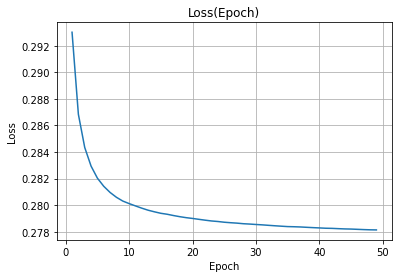

In [7]:

# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns='timestamps')
    y_max_u = y_max_u[utils.cols_with_positive_values(y_max_u)]
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train':X_max_u_train.astype(float),
            'X_test': X_max_u_test.astype(float),
            'y_train':y_max_u_train.astype(float),
            'y_test': y_max_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_max_reg)
    prediction = pd.DataFrame(prediction, columns=y_max_u.columns)
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_max_reg['y_test'][prediction.columns], threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_filtered_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

# Min u

## MLP: Sparse Classification Dataset

[I 2022-10-15 00:36:11,126] A new study created in memory with name: no-name-3a37dc89-b7c6-4578-8769-2188ee1eacd5
[I 2022-10-15 00:37:21,716] Trial 0 finished with value: 0.19312273963481003 and parameters: {'hidden_size': 54, 'n_layers': 2, 'dropout': 0.04150619907232522, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.003611313726690376, 'epochs': 19, 'batch_size': 128}. Best is trial 0 with value: 0.19312273963481003.
[I 2022-10-15 00:40:56,658] Trial 1 finished with value: 0.19142739906909834 and parameters: {'hidden_size': 59, 'n_layers': 1, 'dropout': 0.1926406446533151, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.00017208759790127829, 'epochs': 71, 'batch_size': 1}. Best is trial 0 with value: 0.19312273963481003.
[I 2022-10-15 00:44:10,722] Trial 2 finished with value: 0.1998206325972288 and parameters: {'hidden_size': 49, 'n_layers': 2, 'dropout': 0.23621421196945552, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.06619787674936421, 'epochs': 63, 'batch_size': 

Number of finished trials:  30
Best trial:
  Value: 0.23951377793935183
  Params: 
    hidden_size: 87
    n_layers: 2
    dropout: 0.14018991410841664
    activation: relu
    optimizer: adam
    lr: 0.001819697476093024
    epochs: 92
    batch_size: 256


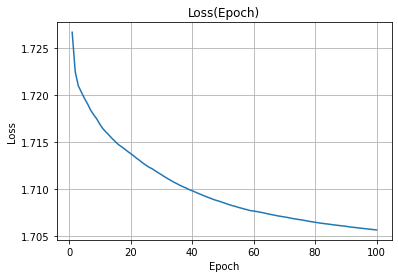

In [8]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns='timestamps')
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_min_u_bool_train, X_min_u_bool_test, y_min_u_bool_train, y_min_u_bool_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u_bool[utils.cols_with_positive_values(y_min_u_bool)], test_size=0.2, scaling=True)
    data = {'X_train':X_min_u_bool_train.astype(float),
            'X_test': X_min_u_bool_test.astype(float),
            'y_train':y_min_u_bool_train.astype(float),
            'y_test': y_min_u_bool_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': True
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_min_class)       
    prediction = pd.DataFrame(prediction, columns=utils.cols_with_positive_values(y_min_u_bool))
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (data_min_class['y_test'][bus] == 1))
        tn += sum((prediction[bus] == 0) & (data_min_class['y_test'][bus] == 0))
        fp += sum((prediction[bus] == 1) & (data_min_class['y_test'][bus] == 0))
        fn += sum((prediction[bus] == 0) & (data_min_class['y_test'][bus] == 1))
    mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_sparse_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,True\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Balanced Classification Dataset

[I 2022-10-15 02:46:07,603] A new study created in memory with name: no-name-aecd78cc-90b5-42b7-a319-d4a6a36cc5f9
[I 2022-10-15 02:47:39,814] Trial 0 finished with value: 0.15083204682087972 and parameters: {'hidden_size': 52, 'n_layers': 3, 'dropout': 0.08727907665312146, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 8.195902523632971e-05, 'epochs': 96, 'batch_size': 4}. Best is trial 0 with value: 0.15083204682087972.
[I 2022-10-15 02:48:12,711] Trial 1 finished with value: 0.16555993256287654 and parameters: {'hidden_size': 86, 'n_layers': 2, 'dropout': 0.41061417266451045, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.000983590877082293, 'epochs': 22, 'batch_size': 16}. Best is trial 1 with value: 0.16555993256287654.
[I 2022-10-15 02:48:43,782] Trial 2 finished with value: 0.15940870851620065 and parameters: {'hidden_size': 30, 'n_layers': 1, 'dropout': 0.1727017214437102, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.0004887623189658662, 'epochs': 39, 'batch_size': 

Number of finished trials:  30
Best trial:
  Value: 0.257341768136932
  Params: 
    hidden_size: 45
    n_layers: 2
    dropout: 0.037390429482101466
    activation: relu
    optimizer: adam
    lr: 0.005879226731277656
    epochs: 81
    batch_size: 512


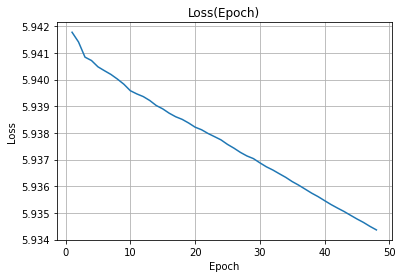

In [9]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_balanced_bool_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_balanced.csv').drop(columns=['date'])
    X_max_u_bool_train, X_max_u_bool_test, y_max_u_bool_train, y_max_u_bool_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u_bool[utils.cols_with_positive_values(y_min_u_bool)], test_size=0.2, scaling=True)
    data = {'X_train':X_max_u_bool_train.astype(float),
            'X_test': X_max_u_bool_test.astype(float),
            'y_train':y_max_u_bool_train.astype(float),
            'y_test': y_max_u_bool_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': True
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_min_class)
    prediction = pd.DataFrame(prediction, columns=utils.cols_with_positive_values(y_min_u_bool))
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (data_min_class['y_test'][bus] == 1))
        tn += sum((prediction[bus] == 0) & (data_min_class['y_test'][bus] == 0))
        fp += sum((prediction[bus] == 1) & (data_min_class['y_test'][bus] == 0))
        fn += sum((prediction[bus] == 0) & (data_min_class['y_test'][bus] == 1))
    mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_balanced_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,True\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Sparse Dataset

[I 2022-10-15 03:22:01,481] A new study created in memory with name: no-name-858448ba-352e-46aa-835b-cbf63d1ea556
[I 2022-10-15 03:23:08,004] Trial 0 finished with value: 0.08160437342930907 and parameters: {'hidden_size': 39, 'n_layers': 2, 'dropout': 0.1206069467651058, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.00479230994909254, 'epochs': 10, 'batch_size': 32}. Best is trial 0 with value: 0.08160437342930907.


true_positives_ctr:  5768
true_negatives_ctr:  245019
false_positives_ctr:  56455
false_negatives_ctr:  254
27707114774373568212


[I 2022-10-15 03:29:54,356] Trial 1 finished with value: 0.08350474882183484 and parameters: {'hidden_size': 37, 'n_layers': 3, 'dropout': 0.033156568943998654, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.06798449246229887, 'epochs': 95, 'batch_size': 32}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  5300
true_negatives_ctr:  252510
false_positives_ctr:  48964
false_negatives_ctr:  722
24947153743905222144


[I 2022-10-15 03:32:19,929] Trial 2 finished with value: 0.07117269520316562 and parameters: {'hidden_size': 45, 'n_layers': 2, 'dropout': 0.31816817796855035, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 1.2173402281724634e-05, 'epochs': 35, 'batch_size': 1024}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  5928
true_negatives_ctr:  232946
false_positives_ctr:  68528
false_negatives_ctr:  94
31500742235615070720


[I 2022-10-15 03:36:43,385] Trial 3 finished with value: 0.07498355905450628 and parameters: {'hidden_size': 50, 'n_layers': 2, 'dropout': 0.4070295178517028, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.00020680005193903674, 'epochs': 73, 'batch_size': 32}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  5901
true_negatives_ctr:  235038
false_positives_ctr:  66436
false_negatives_ctr:  121
30882518670296645524


[I 2022-10-15 03:39:12,889] Trial 4 finished with value: 0.0725914083237115 and parameters: {'hidden_size': 73, 'n_layers': 3, 'dropout': 0.27473579703122286, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.00021150266780088148, 'epochs': 27, 'batch_size': 32}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  5838
true_negatives_ctr:  236033
false_positives_ctr:  65441
false_negatives_ctr:  184
30567742217208808404


[I 2022-10-15 03:42:50,480] Trial 5 finished with value: 0.07021312564936706 and parameters: {'hidden_size': 18, 'n_layers': 1, 'dropout': 0.31614433672858416, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.011683215397391214, 'epochs': 100, 'batch_size': 8}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  6015
true_negatives_ctr:  225982
false_positives_ctr:  75492
false_negatives_ctr:  7
33440504696631709044


[I 2022-10-15 03:48:39,948] Trial 6 finished with value: 0.07907439463819901 and parameters: {'hidden_size': 31, 'n_layers': 3, 'dropout': 0.29183054070061526, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.004570938477617306, 'epochs': 87, 'batch_size': 1024}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  5773
true_negatives_ctr:  247821
false_positives_ctr:  53653
false_negatives_ctr:  249
26763404603316066960


[I 2022-10-15 03:51:03,998] Trial 7 finished with value: 0.07022131607935884 and parameters: {'hidden_size': 36, 'n_layers': 3, 'dropout': 0.12382379198067489, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.049658552286987005, 'epochs': 42, 'batch_size': 1024}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 03:53:23,338] Trial 8 finished with value: 0.0663999583742601 and parameters: {'hidden_size': 31, 'n_layers': 3, 'dropout': 0.253174248765616, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.00016986355398713578, 'epochs': 41, 'batch_size': 256}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  5797
true_negatives_ctr:  208695
false_positives_ctr:  92779
false_negatives_ctr:  225
37388825520255029760


[I 2022-10-15 03:56:36,982] Trial 9 finished with value: 0.07022131607935884 and parameters: {'hidden_size': 78, 'n_layers': 1, 'dropout': 0.31419250243143365, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.021808148954043857, 'epochs': 84, 'batch_size': 32}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 04:00:16,796] Trial 10 finished with value: 0.07295685734824875 and parameters: {'hidden_size': 4, 'n_layers': 3, 'dropout': 0.00612791514017642, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.08843813689317907, 'epochs': 61, 'batch_size': 1}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 04:01:07,743] Trial 11 finished with value: 0.07408068991659532 and parameters: {'hidden_size': 59, 'n_layers': 2, 'dropout': 0.10135970364636519, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.0024852226441750454, 'epochs': 5, 'batch_size': 2}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  5954
true_negatives_ctr:  233825
false_positives_ctr:  67649
false_negatives_ctr:  68
31253837875305937012


[I 2022-10-15 04:01:44,659] Trial 12 finished with value: 0.07113546761049888 and parameters: {'hidden_size': 93, 'n_layers': 2, 'dropout': 0.12778020385050554, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.0010700610846336278, 'epochs': 1, 'batch_size': 128}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 04:02:57,331] Trial 13 finished with value: 0.08014624770879791 and parameters: {'hidden_size': 13, 'n_layers': 1, 'dropout': 0.004101875794265481, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.008851138760453287, 'epochs': 18, 'batch_size': 4}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  5909
true_negatives_ctr:  242117
false_positives_ctr:  59357
false_negatives_ctr:  113
28701562504509681040


[I 2022-10-15 04:06:56,146] Trial 14 finished with value: 0.07552108800215428 and parameters: {'hidden_size': 61, 'n_layers': 2, 'dropout': 0.17226088076809506, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.03422583975316307, 'epochs': 62, 'batch_size': 512}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  5401
true_negatives_ctr:  255708
false_positives_ctr:  45766
false_negatives_ctr:  621
23811037118924651604


[I 2022-10-15 04:09:29,537] Trial 15 finished with value: 0.07220030410874201 and parameters: {'hidden_size': 22, 'n_layers': 2, 'dropout': 0.06111858414734548, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.0011798212060459483, 'epochs': 55, 'batch_size': 64}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  5796
true_negatives_ctr:  237633
false_positives_ctr:  63841
false_negatives_ctr:  226
30071165189145022324


[I 2022-10-15 04:11:00,311] Trial 16 finished with value: 0.07189723173496582 and parameters: {'hidden_size': 42, 'n_layers': 3, 'dropout': 0.18535815314688947, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.004815204441019622, 'epochs': 18, 'batch_size': 16}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  5406
true_negatives_ctr:  249836
false_positives_ctr:  51638
false_negatives_ctr:  616
25937319380594192064


[I 2022-10-15 04:15:08,107] Trial 17 finished with value: 0.07768495427156644 and parameters: {'hidden_size': 59, 'n_layers': 1, 'dropout': 0.06240513736059809, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.09353590580373043, 'epochs': 100, 'batch_size': 32}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  5944
true_negatives_ctr:  239819
false_positives_ctr:  61655
false_negatives_ctr:  78
29441213241250473684


[I 2022-10-15 04:17:29,972] Trial 18 finished with value: -0.05621882740499312 and parameters: {'hidden_size': 1, 'n_layers': 2, 'dropout': 0.46178158011867565, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 4.800108688507558e-05, 'epochs': 77, 'batch_size': 32}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  3690
true_negatives_ctr:  133328
false_positives_ctr:  168146
false_negatives_ctr:  2332
42321064386982073280


[I 2022-10-15 04:18:33,968] Trial 19 finished with value: 0.08048746413689377 and parameters: {'hidden_size': 27, 'n_layers': 2, 'dropout': 0.1975051831907696, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.016532231684420803, 'epochs': 14, 'batch_size': 4}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  5931
true_negatives_ctr:  242291
false_positives_ctr:  59183
false_negatives_ctr:  91
28652686916210390544


[I 2022-10-15 04:21:47,749] Trial 20 finished with value: 0.07203442095717985 and parameters: {'hidden_size': 71, 'n_layers': 3, 'dropout': 0.06206287108316562, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.0033289338706679415, 'epochs': 48, 'batch_size': 256}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  5235
true_negatives_ctr:  256147
false_positives_ctr:  45327
false_negatives_ctr:  787
23585030210337684624


[I 2022-10-15 04:22:56,398] Trial 21 finished with value: 0.07007965892023227 and parameters: {'hidden_size': 27, 'n_layers': 2, 'dropout': 0.1869875867058583, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.014845002567779694, 'epochs': 16, 'batch_size': 2}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  5553
true_negatives_ctr:  245702
false_positives_ctr:  55772
false_negatives_ctr:  469
27407224748709554100


[I 2022-10-15 04:23:42,741] Trial 22 finished with value: 0.058942820101704624 and parameters: {'hidden_size': 39, 'n_layers': 2, 'dropout': 0.22055142146823908, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.0328460040754002, 'epochs': 7, 'batch_size': 4}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  4682
true_negatives_ctr:  249445
false_positives_ctr:  52029
false_negatives_ctr:  1340
25820192551788021780


[I 2022-10-15 04:25:17,807] Trial 23 finished with value: 0.020303643361781084 and parameters: {'hidden_size': 18, 'n_layers': 2, 'dropout': 0.15225609017583058, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.01099855979683438, 'epochs': 32, 'batch_size': 4}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  3603
true_negatives_ctr:  257668
false_positives_ctr:  43806
false_negatives_ctr:  2419
22385667796725349524


[I 2022-10-15 04:26:33,625] Trial 24 finished with value: 0.07632624321310418 and parameters: {'hidden_size': 50, 'n_layers': 1, 'dropout': 0.09029407777003609, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.001782613444445754, 'epochs': 23, 'batch_size': 8}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  5862
true_negatives_ctr:  239327
false_positives_ctr:  62147
false_negatives_ctr:  160
29569157272275459924


[I 2022-10-15 04:27:24,791] Trial 25 finished with value: 0.07314009687091025 and parameters: {'hidden_size': 10, 'n_layers': 2, 'dropout': 0.21891945403958207, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.006964084268241471, 'epochs': 11, 'batch_size': 64}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  5902
true_negatives_ctr:  235511
false_positives_ctr:  65963
false_negatives_ctr:  120
30742591245799076820


[I 2022-10-15 04:28:44,352] Trial 26 finished with value: 0.07022131607935884 and parameters: {'hidden_size': 24, 'n_layers': 3, 'dropout': 0.035151873647412346, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.05255419990058552, 'epochs': 28, 'batch_size': 16}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 04:29:40,377] Trial 27 finished with value: 0.060652614176576955 and parameters: {'hidden_size': 33, 'n_layers': 2, 'dropout': 0.13476906456341287, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.021103570928669213, 'epochs': 11, 'batch_size': 128}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  5401
true_negatives_ctr:  249362
false_positives_ctr:  52112
false_negatives_ctr:  621
26101598921462339412


[I 2022-10-15 04:33:41,774] Trial 28 finished with value: 0.07463277633334447 and parameters: {'hidden_size': 44, 'n_layers': 3, 'dropout': 0.09292176854746101, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.0006944295424754631, 'epochs': 68, 'batch_size': 512}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  5980
true_negatives_ctr:  233625
false_positives_ctr:  67849
false_negatives_ctr:  42
31319511761993471604


[I 2022-10-15 04:35:30,388] Trial 29 finished with value: 0.08057059737583688 and parameters: {'hidden_size': 53, 'n_layers': 1, 'dropout': 0.36603654435705196, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.00039214661909835993, 'epochs': 38, 'batch_size': 4}. Best is trial 1 with value: 0.08350474882183484.


true_positives_ctr:  5867
true_negatives_ctr:  243090
false_positives_ctr:  58384
false_negatives_ctr:  155
28373599075142983860
Number of finished trials:  30
Best trial:
  Value: 0.08350474882183484
  Params: 
    hidden_size: 37
    n_layers: 3
    dropout: 0.033156568943998654
    activation: sigmoid
    optimizer: adam
    lr: 0.06798449246229887
    epochs: 95
    batch_size: 32


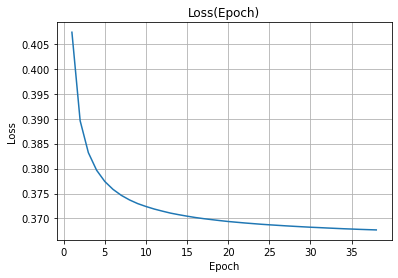

In [10]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns='timestamps')
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_min_u_train, X_min_u_test, y_min_u_train, y_min_u_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train':X_min_u_train.astype(float),
            'X_test': X_min_u_test.astype(float),
            'y_train':y_min_u_train.astype(float),
            'y_test': y_min_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_min_class)
    prediction = pd.DataFrame(prediction, columns=y_min_u.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_min_reg['y_test'], threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_sparse_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Focused Dataset

[I 2022-10-15 04:35:30,596] A new study created in memory with name: no-name-a98cb16f-3356-4c1a-9ccd-84ce12baebcc
[I 2022-10-15 04:36:16,353] Trial 0 finished with value: 0.07022133086092885 and parameters: {'hidden_size': 75, 'n_layers': 2, 'dropout': 0.02048550097613716, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.07881060101236824, 'epochs': 60, 'batch_size': 1024}. Best is trial 0 with value: 0.07022133086092885.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 04:36:52,037] Trial 1 finished with value: 0.0702716337538205 and parameters: {'hidden_size': 48, 'n_layers': 2, 'dropout': 0.41338623815413444, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.0003726947504737234, 'epochs': 22, 'batch_size': 16}. Best is trial 1 with value: 0.0702716337538205.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 04:37:53,326] Trial 2 finished with value: 0.07509838019368609 and parameters: {'hidden_size': 27, 'n_layers': 3, 'dropout': 0.08157991009868754, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.0005054913114628038, 'epochs': 71, 'batch_size': 1024}. Best is trial 2 with value: 0.07509838019368609.


true_positives_ctr:  6013
true_negatives_ctr:  229889
false_positives_ctr:  71585
false_negatives_ctr:  9
32387418679121405712


[I 2022-10-15 04:38:33,703] Trial 3 finished with value: 0.07022154546482226 and parameters: {'hidden_size': 29, 'n_layers': 1, 'dropout': 0.4894020284116593, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.008773660099485376, 'epochs': 53, 'batch_size': 256}. Best is trial 2 with value: 0.07509838019368609.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 04:39:30,114] Trial 4 finished with value: 0.057746801894188564 and parameters: {'hidden_size': 75, 'n_layers': 2, 'dropout': 0.3255142897356347, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 2.9472692001548127e-05, 'epochs': 92, 'batch_size': 128}. Best is trial 2 with value: 0.07509838019368609.


true_positives_ctr:  4527
true_negatives_ctr:  184357
false_positives_ctr:  117117
false_negatives_ctr:  1495
41043892928457622464


[I 2022-10-15 04:40:11,609] Trial 5 finished with value: 0.07022131607935884 and parameters: {'hidden_size': 83, 'n_layers': 3, 'dropout': 0.37480136110738577, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.04721057577968519, 'epochs': 36, 'batch_size': 32}. Best is trial 2 with value: 0.07509838019368609.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 04:41:15,106] Trial 6 finished with value: 0.0702214018175804 and parameters: {'hidden_size': 70, 'n_layers': 3, 'dropout': 0.10012653212095513, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.000780091614378967, 'epochs': 95, 'batch_size': 2}. Best is trial 2 with value: 0.07509838019368609.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 04:42:22,037] Trial 7 finished with value: 0.06297893971004229 and parameters: {'hidden_size': 91, 'n_layers': 3, 'dropout': 0.3271541987238019, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0023729111215839535, 'epochs': 62, 'batch_size': 256}. Best is trial 2 with value: 0.07509838019368609.


true_positives_ctr:  5361
true_negatives_ctr:  248633
false_positives_ctr:  52841
false_negatives_ctr:  661
26341490728115906064


[I 2022-10-15 04:43:20,050] Trial 8 finished with value: 0.07070492818727914 and parameters: {'hidden_size': 87, 'n_layers': 2, 'dropout': 0.3695604143192413, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.0003761558830752223, 'epochs': 98, 'batch_size': 32}. Best is trial 2 with value: 0.07509838019368609.


true_positives_ctr:  6014
true_negatives_ctr:  225931
false_positives_ctr:  75543
false_negatives_ctr:  8
33453615341204153844


[I 2022-10-15 04:44:03,364] Trial 9 finished with value: 0.07115639852751798 and parameters: {'hidden_size': 38, 'n_layers': 1, 'dropout': 0.24806186970129673, 'activation': 'relu', 'optimizer': 'adam', 'lr': 2.3509834703111444e-05, 'epochs': 49, 'batch_size': 1}. Best is trial 2 with value: 0.07509838019368609.


true_positives_ctr:  5965
true_negatives_ctr:  230544
false_positives_ctr:  70930
false_negatives_ctr:  57
32192144021162367060


[I 2022-10-15 04:44:57,914] Trial 10 finished with value: 0.0729754054354944 and parameters: {'hidden_size': 2, 'n_layers': 3, 'dropout': 0.17165446761687514, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.00010764027769412383, 'epochs': 76, 'batch_size': 1024}. Best is trial 2 with value: 0.07509838019368609.


true_positives_ctr:  5902
true_negatives_ctr:  235024
false_positives_ctr:  66450
false_negatives_ctr:  120
30886952254358846464


[I 2022-10-15 04:45:52,654] Trial 11 finished with value: 0.07917564318556279 and parameters: {'hidden_size': 1, 'n_layers': 3, 'dropout': 0.1600955344976216, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 8.705466688882953e-05, 'epochs': 75, 'batch_size': 1024}. Best is trial 11 with value: 0.07917564318556279.


true_positives_ctr:  5829
true_negatives_ctr:  237568
false_positives_ctr:  63906
false_negatives_ctr:  193
30101077254725167380


[I 2022-10-15 04:46:47,552] Trial 12 finished with value: 0.06959004708054173 and parameters: {'hidden_size': 3, 'n_layers': 3, 'dropout': 0.12997068217046945, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.00010199441379279544, 'epochs': 77, 'batch_size': 1024}. Best is trial 11 with value: 0.07917564318556279.


true_positives_ctr:  5902
true_negatives_ctr:  235045
false_positives_ctr:  66429
false_negatives_ctr:  120
30880745007921735220


[I 2022-10-15 04:47:45,944] Trial 13 finished with value: 0.07614667593799465 and parameters: {'hidden_size': 19, 'n_layers': 3, 'dropout': 0.009234380883378634, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.002404522263746786, 'epochs': 77, 'batch_size': 4}. Best is trial 11 with value: 0.07917564318556279.


true_positives_ctr:  6010
true_negatives_ctr:  232982
false_positives_ctr:  68492
false_negatives_ctr:  12
31513982047704414864


[I 2022-10-15 04:48:45,801] Trial 14 finished with value: 0.07172596420375815 and parameters: {'hidden_size': 14, 'n_layers': 3, 'dropout': 0.021127435661406846, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.004138493135163969, 'epochs': 82, 'batch_size': 4}. Best is trial 11 with value: 0.07917564318556279.


true_positives_ctr:  5945
true_negatives_ctr:  234228
false_positives_ctr:  67246
false_negatives_ctr:  77
31133636589817765140


[I 2022-10-15 04:49:26,508] Trial 15 finished with value: 0.07060465267838205 and parameters: {'hidden_size': 14, 'n_layers': 2, 'dropout': 0.20729004773480184, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.018303649578425365, 'epochs': 39, 'batch_size': 8}. Best is trial 11 with value: 0.07917564318556279.


true_positives_ctr:  5909
true_negatives_ctr:  233698
false_positives_ctr:  67776
false_negatives_ctr:  113
31277687890807252980


[I 2022-10-15 04:49:55,167] Trial 16 finished with value: -0.023492662792289513 and parameters: {'hidden_size': 17, 'n_layers': 3, 'dropout': 0.0024266588007226877, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 1.0355065648846371e-05, 'epochs': 5, 'batch_size': 64}. Best is trial 11 with value: 0.07917564318556279.


true_positives_ctr:  2776
true_negatives_ctr:  181524
false_positives_ctr:  119950
false_negatives_ctr:  3246
41167894202181052560


[I 2022-10-15 04:50:52,372] Trial 17 finished with value: 0.07244026938267224 and parameters: {'hidden_size': 57, 'n_layers': 1, 'dropout': 0.1574794229248598, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.00012341167675311186, 'epochs': 83, 'batch_size': 512}. Best is trial 11 with value: 0.07917564318556279.


true_positives_ctr:  6015
true_negatives_ctr:  228558
false_positives_ctr:  72916
false_negatives_ctr:  7
32752763359985938420


[I 2022-10-15 04:51:52,598] Trial 18 finished with value: 0.07540960488971754 and parameters: {'hidden_size': 26, 'n_layers': 3, 'dropout': 0.07605392807162739, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.0020767200109402194, 'epochs': 65, 'batch_size': 4}. Best is trial 11 with value: 0.07917564318556279.


true_positives_ctr:  5994
true_negatives_ctr:  232867
false_positives_ctr:  68607
false_negatives_ctr:  28
31542450364732575060


[I 2022-10-15 04:52:54,280] Trial 19 finished with value: 0.07230268325398044 and parameters: {'hidden_size': 41, 'n_layers': 2, 'dropout': 0.2507957564811547, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.0014891877819760513, 'epochs': 88, 'batch_size': 4}. Best is trial 11 with value: 0.07917564318556279.


true_positives_ctr:  5886
true_negatives_ctr:  234692
false_positives_ctr:  66782
false_negatives_ctr:  136
30980163200363416512


[I 2022-10-15 04:53:49,090] Trial 20 finished with value: 0.07288606511451856 and parameters: {'hidden_size': 8, 'n_layers': 3, 'dropout': 0.2154872453847062, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.007731120420881039, 'epochs': 70, 'batch_size': 8}. Best is trial 11 with value: 0.07917564318556279.


true_positives_ctr:  5867
true_negatives_ctr:  236719
false_positives_ctr:  64755
false_negatives_ctr:  155
30370225798063616784


[I 2022-10-15 04:54:48,037] Trial 21 finished with value: 0.07579608017149786 and parameters: {'hidden_size': 26, 'n_layers': 3, 'dropout': 0.06409586493761715, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.0024073916858708415, 'epochs': 64, 'batch_size': 4}. Best is trial 11 with value: 0.07917564318556279.


true_positives_ctr:  6001
true_negatives_ctr:  233068
false_positives_ctr:  68406
false_negatives_ctr:  21
31486630506477127444


[I 2022-10-15 04:55:36,214] Trial 22 finished with value: 0.07004029977594793 and parameters: {'hidden_size': 21, 'n_layers': 3, 'dropout': 0.05797584684782659, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.004326300390400969, 'epochs': 52, 'batch_size': 4}. Best is trial 11 with value: 0.07917564318556279.


true_positives_ctr:  5938
true_negatives_ctr:  233025
false_positives_ctr:  68449
false_negatives_ctr:  84
31480868111675598324


[I 2022-10-15 04:56:37,634] Trial 23 finished with value: 0.07219634431615948 and parameters: {'hidden_size': 35, 'n_layers': 3, 'dropout': 0.12697775041754084, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.00020291258790721377, 'epochs': 72, 'batch_size': 4}. Best is trial 11 with value: 0.07917564318556279.


true_positives_ctr:  6015
true_negatives_ctr:  228225
false_positives_ctr:  73249
false_negatives_ctr:  7
32843023824562822144


[I 2022-10-15 04:57:42,854] Trial 24 finished with value: 0.07513149764957809 and parameters: {'hidden_size': 100, 'n_layers': 2, 'dropout': 0.04109965078321588, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.0010666582251818016, 'epochs': 84, 'batch_size': 64}. Best is trial 11 with value: 0.07917564318556279.


true_positives_ctr:  6009
true_negatives_ctr:  231893
false_positives_ctr:  69581
false_negatives_ctr:  13
31824892465524543120


[I 2022-10-15 04:58:26,629] Trial 25 finished with value: 0.07634792375487974 and parameters: {'hidden_size': 9, 'n_layers': 3, 'dropout': 0.11352588043650862, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.02235323018377077, 'epochs': 44, 'batch_size': 16}. Best is trial 11 with value: 0.07917564318556279.


true_positives_ctr:  5995
true_negatives_ctr:  233330
false_positives_ctr:  68144
false_negatives_ctr:  27
31409293752311326644


[I 2022-10-15 04:59:08,481] Trial 26 finished with value: 0.0773407618625662 and parameters: {'hidden_size': 7, 'n_layers': 3, 'dropout': 0.12375711183048213, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.024128172706340115, 'epochs': 37, 'batch_size': 16}. Best is trial 11 with value: 0.07917564318556279.


true_positives_ctr:  5968
true_negatives_ctr:  236149
false_positives_ctr:  65325
false_negatives_ctr:  54
30571934036090569012


[I 2022-10-15 04:59:45,302] Trial 27 finished with value: 0.07392651882798533 and parameters: {'hidden_size': 8, 'n_layers': 2, 'dropout': 0.18227973588484367, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.029756319712758328, 'epochs': 28, 'batch_size': 16}. Best is trial 11 with value: 0.07917564318556279.


true_positives_ctr:  6011
true_negatives_ctr:  230428
false_positives_ctr:  71046
false_negatives_ctr:  11
32237302414213421844


[I 2022-10-15 05:00:29,883] Trial 28 finished with value: 0.0729265509900161 and parameters: {'hidden_size': 10, 'n_layers': 3, 'dropout': 0.11342931960372801, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.015954147100957102, 'epochs': 42, 'batch_size': 16}. Best is trial 11 with value: 0.07917564318556279.


true_positives_ctr:  5956
true_negatives_ctr:  233355
false_positives_ctr:  68119
false_negatives_ctr:  66
31390786698461426100


[I 2022-10-15 05:01:01,434] Trial 29 finished with value: 0.07045237359007829 and parameters: {'hidden_size': 1, 'n_layers': 2, 'dropout': 0.2615268367275516, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.09422745139362579, 'epochs': 18, 'batch_size': 16}. Best is trial 11 with value: 0.07917564318556279.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800
Number of finished trials:  30
Best trial:
  Value: 0.07917564318556279
  Params: 
    hidden_size: 1
    n_layers: 3
    dropout: 0.1600955344976216
    activation: tanh
    optimizer: adam
    lr: 8.705466688882953e-05
    epochs: 75
    batch_size: 1024


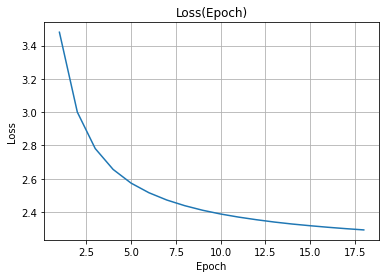

In [11]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_focused_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_focused.csv').drop(columns=['date'])
    X_min_u_train, X_min_u_test, y_min_u_train, y_min_u_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u, scaling=True)
    data = {'X_train':X_min_u_train.astype(float),
            'X_test': X_min_u_test.astype(float),
            'y_train':y_min_u_train.astype(float),
            'y_test': y_min_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    # print(model.strategy.model.eval())
    prediction = model.predict(data_min_reg)
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_min_reg['y_test'], threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_focused_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

## Regression Filtered Dataset

[I 2022-10-15 05:01:01,654] A new study created in memory with name: no-name-d472b947-4689-416b-9b57-20f01b0c1cbc
[I 2022-10-15 05:03:06,446] Trial 0 finished with value: -0.076459237209601 and parameters: {'hidden_size': 2, 'n_layers': 1, 'dropout': 0.09954661587574865, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.00010919669880991307, 'epochs': 94, 'batch_size': 1}. Best is trial 0 with value: -0.076459237209601.


true_positives_ctr:  2566
true_negatives_ctr:  54903
false_positives_ctr:  38559
false_negatives_ctr:  3456
1350795402840775500


[I 2022-10-15 05:05:03,702] Trial 1 finished with value: -0.01720685480857901 and parameters: {'hidden_size': 57, 'n_layers': 3, 'dropout': 0.467295523416835, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.009323819948888661, 'epochs': 33, 'batch_size': 512}. Best is trial 1 with value: -0.01720685480857901.


true_positives_ctr:  4793
true_negatives_ctr:  51824
false_positives_ctr:  41638
false_negatives_ctr:  1229
1386416779329834252


[I 2022-10-15 05:07:59,138] Trial 2 finished with value: -0.029373171731267828 and parameters: {'hidden_size': 38, 'n_layers': 2, 'dropout': 0.26223916699350097, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.0027323376069819795, 'epochs': 62, 'batch_size': 128}. Best is trial 1 with value: -0.01720685480857901.


true_positives_ctr:  4575
true_negatives_ctr:  51784
false_positives_ctr:  41678
false_negatives_ctr:  1447
1385735532120128652


[I 2022-10-15 05:10:39,372] Trial 3 finished with value: -0.0017865648764128121 and parameters: {'hidden_size': 97, 'n_layers': 1, 'dropout': 0.4794070557833581, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.0009059830777262195, 'epochs': 91, 'batch_size': 1024}. Best is trial 3 with value: -0.0017865648764128121.


true_positives_ctr:  5514
true_negatives_ctr:  39532
false_positives_ctr:  53930
false_negatives_ctr:  508
1339608565527872640


[I 2022-10-15 05:10:59,159] Trial 4 finished with value: 0.016918652070123722 and parameters: {'hidden_size': 92, 'n_layers': 1, 'dropout': 0.1737004148664843, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0006162648908124374, 'epochs': 5, 'batch_size': 8}. Best is trial 4 with value: 0.016918652070123722.


true_positives_ctr:  5587
true_negatives_ctr:  46045
false_positives_ctr:  47417
false_negatives_ctr:  435
1386598053336410880


[I 2022-10-15 05:12:18,979] Trial 5 finished with value: -0.0013413309857528337 and parameters: {'hidden_size': 57, 'n_layers': 2, 'dropout': 0.11880826716015863, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.0006815775241504844, 'epochs': 25, 'batch_size': 32}. Best is trial 4 with value: 0.016918652070123722.


true_positives_ctr:  5302
true_negatives_ctr:  47018
false_positives_ctr:  46444
false_negatives_ctr:  720
1390326580550833872


[I 2022-10-15 05:12:51,174] Trial 6 finished with value: -0.06622422994173441 and parameters: {'hidden_size': 73, 'n_layers': 3, 'dropout': 0.44742191182743607, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 1.6793608603487607e-05, 'epochs': 10, 'batch_size': 16}. Best is trial 4 with value: 0.016918652070123722.


true_positives_ctr:  2102
true_negatives_ctr:  61443
false_positives_ctr:  32019
false_negatives_ctr:  3920
1255248032251395372


[I 2022-10-15 05:16:19,436] Trial 7 finished with value: -0.001943214861684459 and parameters: {'hidden_size': 64, 'n_layers': 1, 'dropout': 0.2741011386571654, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.00028163876174930953, 'epochs': 96, 'batch_size': 32}. Best is trial 4 with value: 0.016918652070123722.


true_positives_ctr:  5327
true_negatives_ctr:  45339
false_positives_ctr:  48123
false_negatives_ctr:  695
1384848434449237200


[I 2022-10-15 05:19:43,581] Trial 8 finished with value: -0.012387967124656566 and parameters: {'hidden_size': 14, 'n_layers': 2, 'dropout': 0.11581796486373958, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.0010899088298718992, 'epochs': 95, 'batch_size': 128}. Best is trial 4 with value: 0.016918652070123722.


true_positives_ctr:  5195
true_negatives_ctr:  47893
false_positives_ctr:  45569
false_negatives_ctr:  827
1391999042450661120


[I 2022-10-15 05:21:12,245] Trial 9 finished with value: 0.03604304726158007 and parameters: {'hidden_size': 6, 'n_layers': 1, 'dropout': 0.3891552250970304, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.000259344726467075, 'epochs': 63, 'batch_size': 8}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  4100
true_negatives_ctr:  58759
false_positives_ctr:  34703
false_negatives_ctr:  1922
1325237920731198252


[I 2022-10-15 05:23:00,469] Trial 10 finished with value: 0.029864153964816533 and parameters: {'hidden_size': 33, 'n_layers': 1, 'dropout': 0.3717951100620178, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.053445300798707254, 'epochs': 64, 'batch_size': 8}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  5901
true_negatives_ctr:  32619
false_positives_ctr:  60843
false_negatives_ctr:  121
1229891293500243840


[I 2022-10-15 05:24:53,790] Trial 11 finished with value: 0.027594813874539978 and parameters: {'hidden_size': 29, 'n_layers': 1, 'dropout': 0.36613768382677686, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.056800676622153816, 'epochs': 66, 'batch_size': 8}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  5913
true_negatives_ctr:  30389
false_positives_ctr:  63073
false_negatives_ctr:  109
1184153888984528592


[I 2022-10-15 05:26:31,084] Trial 12 finished with value: 0.026522298876224145 and parameters: {'hidden_size': 24, 'n_layers': 1, 'dropout': 0.3433405242284493, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.040163299725397596, 'epochs': 70, 'batch_size': 64}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  5911
true_negatives_ctr:  29993
false_positives_ctr:  63469
false_negatives_ctr:  111
1175531638423505280


[I 2022-10-15 05:28:06,123] Trial 13 finished with value: 0.02031306555377141 and parameters: {'hidden_size': 40, 'n_layers': 2, 'dropout': 0.006959710474816666, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 4.6648109159098134e-05, 'epochs': 47, 'batch_size': 2}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  4581
true_negatives_ctr:  37673
false_positives_ctr:  55789
false_negatives_ctr:  1441
1329012998900237520


[I 2022-10-15 05:29:52,208] Trial 14 finished with value: -0.01711145266033601 and parameters: {'hidden_size': 5, 'n_layers': 1, 'dropout': 0.3832094976059291, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.005260257197350465, 'epochs': 79, 'batch_size': 4}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  5372
true_negatives_ctr:  40281
false_positives_ctr:  53181
false_negatives_ctr:  650
1348892462807790252


[I 2022-10-15 05:31:15,958] Trial 15 finished with value: 0.011838019843569487 and parameters: {'hidden_size': 18, 'n_layers': 2, 'dropout': 0.303825852423558, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.017269022281835075, 'epochs': 49, 'batch_size': 256}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  5807
true_negatives_ctr:  30503
false_positives_ctr:  62959
false_negatives_ctr:  215
1188892316784118032


[I 2022-10-15 05:33:23,294] Trial 16 finished with value: 0.01805458064810396 and parameters: {'hidden_size': 39, 'n_layers': 1, 'dropout': 0.404911842382592, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 9.938290079189894e-05, 'epochs': 78, 'batch_size': 8}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  4763
true_negatives_ctr:  50731
false_positives_ctr:  42731
false_negatives_ctr:  1259
1389742653084621840


[I 2022-10-15 05:35:12,282] Trial 17 finished with value: 0.018644715372872545 and parameters: {'hidden_size': 15, 'n_layers': 3, 'dropout': 0.1961676387118103, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.09881858819862693, 'epochs': 57, 'batch_size': 8}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  5902
true_negatives_ctr:  27016
false_positives_ctr:  66446
false_negatives_ctr:  120
1104964135158177792


[I 2022-10-15 05:36:22,270] Trial 18 finished with value: -0.06546679446635449 and parameters: {'hidden_size': 32, 'n_layers': 1, 'dropout': 0.3240977581501298, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 1.0062444681609162e-05, 'epochs': 38, 'batch_size': 8}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  1507
true_negatives_ctr:  69592
false_positives_ctr:  23870
false_negatives_ctr:  4515
1058462152783279596


[I 2022-10-15 05:38:55,065] Trial 19 finished with value: 0.004580683773679236 and parameters: {'hidden_size': 46, 'n_layers': 2, 'dropout': 0.41901686168831553, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.002354994074565529, 'epochs': 76, 'batch_size': 1}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  5669
true_negatives_ctr:  34783
false_positives_ctr:  58679
false_negatives_ctr:  353
1272515828268321792


[I 2022-10-15 05:40:30,481] Trial 20 finished with value: -0.009496330501940969 and parameters: {'hidden_size': 77, 'n_layers': 1, 'dropout': 0.42152346796809625, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.00022189517907908064, 'epochs': 55, 'batch_size': 1024}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  5068
true_negatives_ctr:  48023
false_positives_ctr:  45439
false_negatives_ctr:  954
1392257526350431596


[I 2022-10-15 05:42:19,177] Trial 21 finished with value: 0.029350660466198334 and parameters: {'hidden_size': 26, 'n_layers': 1, 'dropout': 0.36378153257954765, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.08373735059743236, 'epochs': 67, 'batch_size': 8}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  5928
true_negatives_ctr:  30111
false_positives_ctr:  63351
false_negatives_ctr:  94
1177758566549299980


[I 2022-10-15 05:44:10,414] Trial 22 finished with value: 0.01385996083373336 and parameters: {'hidden_size': 8, 'n_layers': 1, 'dropout': 0.4959250368956559, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.04148772893165798, 'epochs': 82, 'batch_size': 8}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  5794
true_negatives_ctr:  33076
false_positives_ctr:  60386
false_negatives_ctr:  228
1240506322725790080


[I 2022-10-15 05:45:46,670] Trial 23 finished with value: 0.013292790146952355 and parameters: {'hidden_size': 23, 'n_layers': 1, 'dropout': 0.356234246003322, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.012803339676479295, 'epochs': 69, 'batch_size': 8}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  5799
true_negatives_ctr:  31117
false_positives_ctr:  62345
false_negatives_ctr:  223
1201994377854685440


[I 2022-10-15 05:47:04,663] Trial 24 finished with value: 0.021280670518416683 and parameters: {'hidden_size': 29, 'n_layers': 1, 'dropout': 0.30189738888739787, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.02358453667521138, 'epochs': 44, 'batch_size': 16}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  5799
true_negatives_ctr:  34794
false_positives_ctr:  58668
false_negatives_ctr:  223
1270551339035805996


[I 2022-10-15 05:48:41,197] Trial 25 finished with value: 0.01073970422033062 and parameters: {'hidden_size': 13, 'n_layers': 2, 'dropout': 0.388401438504347, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.07460448381094661, 'epochs': 58, 'batch_size': 2}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  5805
true_negatives_ctr:  30551
false_positives_ctr:  62911
false_negatives_ctr:  217
1189961634012901632


[I 2022-10-15 05:50:56,821] Trial 26 finished with value: 0.020293454822621602 and parameters: {'hidden_size': 48, 'n_layers': 1, 'dropout': 0.20562201118946197, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.006237874603040386, 'epochs': 85, 'batch_size': 64}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  5819
true_negatives_ctr:  32683
false_positives_ctr:  60779
false_negatives_ctr:  203
1232673503952843792


[I 2022-10-15 05:52:31,630] Trial 27 finished with value: 0.022676480983461783 and parameters: {'hidden_size': 23, 'n_layers': 1, 'dropout': 0.44450858261085946, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.02823235122620654, 'epochs': 69, 'batch_size': 4}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  5895
true_negatives_ctr:  29276
false_positives_ctr:  64186
false_negatives_ctr:  127
1159759011183433452


[I 2022-10-15 05:53:19,872] Trial 28 finished with value: -0.0009421218017961495 and parameters: {'hidden_size': 9, 'n_layers': 2, 'dropout': 0.22721327257027168, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.002939346950959245, 'epochs': 27, 'batch_size': 256}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  5188
true_negatives_ctr:  46346
false_positives_ctr:  47116
false_negatives_ctr:  834
1388892591195406080


[I 2022-10-15 05:54:44,721] Trial 29 finished with value: -0.14151056532526074 and parameters: {'hidden_size': 2, 'n_layers': 1, 'dropout': 0.3272533370304652, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 5.0317675147067545e-05, 'epochs': 62, 'batch_size': 512}. Best is trial 9 with value: 0.03604304726158007.


true_positives_ctr:  3169
true_negatives_ctr:  39608
false_positives_ctr:  53854
false_negatives_ctr:  2853
1362749719954874892
Number of finished trials:  30
Best trial:
  Value: 0.03604304726158007
  Params: 
    hidden_size: 6
    n_layers: 1
    dropout: 0.3891552250970304
    activation: relu
    optimizer: sgd
    lr: 0.000259344726467075
    epochs: 63
    batch_size: 8


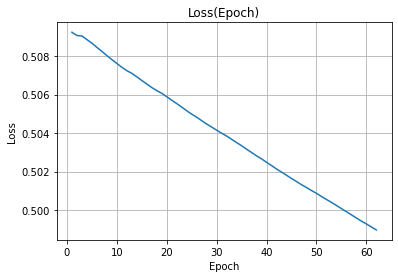

In [12]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns='timestamps')
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_min_u_train, X_min_u_test, y_min_u_train, y_min_u_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u[utils.cols_with_positive_values(y_min_u)], test_size=0.2, scaling=True)
    data = {'X_train':X_min_u_train.astype(float),
            'X_test': X_min_u_test.astype(float),
            'y_train':y_min_u_train.astype(float),
            'y_test': y_min_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_min_reg)
    prediction = pd.DataFrame(prediction, columns=utils.cols_with_positive_values(y_min_u))
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_min_reg['y_test'][prediction.columns], threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_filtered_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Balanced Dataset

[I 2022-10-15 05:54:44,916] A new study created in memory with name: no-name-fe658c66-2d6e-41c3-9e2f-74c63557155c
[I 2022-10-15 05:55:52,890] Trial 0 finished with value: 0.0722664233500215 and parameters: {'hidden_size': 28, 'n_layers': 1, 'dropout': 0.4437878612204131, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.0030576275478803143, 'epochs': 59, 'batch_size': 512}. Best is trial 0 with value: 0.0722664233500215.


true_positives_ctr:  5803
true_negatives_ctr:  239122
false_positives_ctr:  62352
false_negatives_ctr:  219
29614570456550325940


[I 2022-10-15 05:57:41,373] Trial 1 finished with value: 0.07427763887558057 and parameters: {'hidden_size': 45, 'n_layers': 3, 'dropout': 0.47125569953579616, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.00019877564106600835, 'epochs': 76, 'batch_size': 1024}. Best is trial 1 with value: 0.07427763887558057.


true_positives_ctr:  6014
true_negatives_ctr:  228628
false_positives_ctr:  72846
false_negatives_ctr:  8
32733466561181522880


[I 2022-10-15 05:58:31,964] Trial 2 finished with value: 0.07962739172011546 and parameters: {'hidden_size': 93, 'n_layers': 1, 'dropout': 0.04719477983379511, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.0001130930849238181, 'epochs': 46, 'batch_size': 16}. Best is trial 2 with value: 0.07962739172011546.


true_positives_ctr:  5697
true_negatives_ctr:  221574
false_positives_ctr:  79900
false_negatives_ctr:  325
34482957216351992884


[I 2022-10-15 05:59:23,129] Trial 3 finished with value: 0.07022132856209035 and parameters: {'hidden_size': 44, 'n_layers': 1, 'dropout': 0.12622609980456279, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.003836199894658823, 'epochs': 50, 'batch_size': 2}. Best is trial 2 with value: 0.07962739172011546.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 06:00:20,036] Trial 4 finished with value: 0.04484373192299429 and parameters: {'hidden_size': 26, 'n_layers': 3, 'dropout': 0.07746028426555707, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 4.87550264681689e-05, 'epochs': 46, 'batch_size': 1}. Best is trial 2 with value: 0.07962739172011546.


true_positives_ctr:  4390
true_negatives_ctr:  174874
false_positives_ctr:  126600
false_negatives_ctr:  1632
41974760769650402320


[I 2022-10-15 06:01:48,557] Trial 5 finished with value: 0.07112125790676696 and parameters: {'hidden_size': 51, 'n_layers': 1, 'dropout': 0.41024572885007277, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 1.8679242464402856e-05, 'epochs': 94, 'batch_size': 32}. Best is trial 2 with value: 0.07962739172011546.


true_positives_ctr:  5927
true_negatives_ctr:  233060
false_positives_ctr:  68414
false_negatives_ctr:  95
31467609091845645940


[I 2022-10-15 06:03:12,114] Trial 6 finished with value: 0.07543187544690648 and parameters: {'hidden_size': 59, 'n_layers': 1, 'dropout': 0.3113055876904153, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.003132649973967262, 'epochs': 85, 'batch_size': 128}. Best is trial 2 with value: 0.07962739172011546.


true_positives_ctr:  5444
true_negatives_ctr:  251694
false_positives_ctr:  49780
false_negatives_ctr:  578
25292253446198429184


[I 2022-10-15 06:04:12,982] Trial 7 finished with value: 0.07253160122148282 and parameters: {'hidden_size': 98, 'n_layers': 1, 'dropout': 0.2964270564402838, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.0005756575979621753, 'epochs': 68, 'batch_size': 512}. Best is trial 2 with value: 0.07962739172011546.


true_positives_ctr:  6015
true_negatives_ctr:  226287
false_positives_ctr:  75187
false_negatives_ctr:  7
33360333194029554064


[I 2022-10-15 06:06:00,530] Trial 8 finished with value: 0.06999489165253407 and parameters: {'hidden_size': 78, 'n_layers': 2, 'dropout': 0.16062146785394088, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.09069625314637035, 'epochs': 74, 'batch_size': 2}. Best is trial 2 with value: 0.07962739172011546.


true_positives_ctr:  6011
true_negatives_ctr:  226197
false_positives_ctr:  75277
false_negatives_ctr:  11
33382973121872550912


[I 2022-10-15 06:06:36,425] Trial 9 finished with value: 0.07031399350575211 and parameters: {'hidden_size': 23, 'n_layers': 2, 'dropout': 0.41231770063036105, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.0004556964997017767, 'epochs': 12, 'batch_size': 512}. Best is trial 2 with value: 0.07962739172011546.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 06:07:16,686] Trial 10 finished with value: -0.07215152214022032 and parameters: {'hidden_size': 2, 'n_layers': 2, 'dropout': 0.0015927062443186271, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 8.110773512932194e-05, 'epochs': 26, 'batch_size': 16}. Best is trial 2 with value: 0.07962739172011546.


true_positives_ctr:  3762
true_negatives_ctr:  117036
false_positives_ctr:  184438
false_negatives_ctr:  2260
40760182094672281600


[I 2022-10-15 06:08:33,651] Trial 11 finished with value: 0.06991550776944942 and parameters: {'hidden_size': 77, 'n_layers': 1, 'dropout': 0.2611265836411404, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.0158624144310845, 'epochs': 99, 'batch_size': 128}. Best is trial 2 with value: 0.07962739172011546.


true_positives_ctr:  6016
true_negatives_ctr:  225404
false_positives_ctr:  76070
false_negatives_ctr:  6
33591769896690011280


[I 2022-10-15 06:09:27,648] Trial 12 finished with value: 0.0849208198050504 and parameters: {'hidden_size': 99, 'n_layers': 1, 'dropout': 0.32300549528113404, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0023906736593465, 'epochs': 35, 'batch_size': 256}. Best is trial 12 with value: 0.0849208198050504.


true_positives_ctr:  5808
true_negatives_ctr:  247469
false_positives_ctr:  54005
false_negatives_ctr:  214
26895671971781687412


[I 2022-10-15 06:10:18,909] Trial 13 finished with value: 0.10029660443902289 and parameters: {'hidden_size': 100, 'n_layers': 2, 'dropout': 0.1925359507152277, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.00013869685521641104, 'epochs': 34, 'batch_size': 8}. Best is trial 13 with value: 0.10029660443902289.


true_positives_ctr:  5789
true_negatives_ctr:  229878
false_positives_ctr:  71596
false_negatives_ctr:  233
32328442438994666580


[I 2022-10-15 06:11:05,207] Trial 14 finished with value: 0.0726329850657071 and parameters: {'hidden_size': 83, 'n_layers': 2, 'dropout': 0.19592342787010952, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.001000083584672563, 'epochs': 29, 'batch_size': 256}. Best is trial 13 with value: 0.10029660443902289.


true_positives_ctr:  6012
true_negatives_ctr:  226481
false_positives_ctr:  74993
false_negatives_ctr:  10
33308370749344258740


[I 2022-10-15 06:12:13,342] Trial 15 finished with value: 0.07154139823142917 and parameters: {'hidden_size': 69, 'n_layers': 3, 'dropout': 0.3506790034413801, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0161105482886729, 'epochs': 31, 'batch_size': 8}. Best is trial 13 with value: 0.10029660443902289.


true_positives_ctr:  5576
true_negatives_ctr:  248102
false_positives_ctr:  53372
false_negatives_ctr:  446
26599284960534315712


[I 2022-10-15 06:12:46,128] Trial 16 finished with value: -0.06075559517084966 and parameters: {'hidden_size': 100, 'n_layers': 2, 'dropout': 0.20034392138522591, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 1.7090217426686404e-05, 'epochs': 8, 'batch_size': 64}. Best is trial 13 with value: 0.10029660443902289.


true_positives_ctr:  808
true_negatives_ctr:  228492
false_positives_ctr:  72982
false_negatives_ctr:  5214
31308191897923176720


[I 2022-10-15 06:13:33,588] Trial 17 finished with value: 0.07687697216831268 and parameters: {'hidden_size': 88, 'n_layers': 3, 'dropout': 0.2354082650999839, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0002814821808513643, 'epochs': 18, 'batch_size': 256}. Best is trial 13 with value: 0.10029660443902289.


true_positives_ctr:  6012
true_negatives_ctr:  232996
false_positives_ctr:  68478
false_negatives_ctr:  10
31510528924395490320


[I 2022-10-15 06:14:34,585] Trial 18 finished with value: 0.07513676321758585 and parameters: {'hidden_size': 69, 'n_layers': 2, 'dropout': 0.35484492535890505, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.0011478419798376892, 'epochs': 38, 'batch_size': 8}. Best is trial 13 with value: 0.10029660443902289.


true_positives_ctr:  6012
true_negatives_ctr:  230182
false_positives_ctr:  71292
false_negatives_ctr:  10
32305971620965461504


[I 2022-10-15 06:15:43,362] Trial 19 finished with value: 0.06977971683292931 and parameters: {'hidden_size': 87, 'n_layers': 2, 'dropout': 0.3594629352590528, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.009584684143594278, 'epochs': 60, 'batch_size': 4}. Best is trial 13 with value: 0.10029660443902289.


true_positives_ctr:  6015
true_negatives_ctr:  225341
false_positives_ctr:  76133
false_negatives_ctr:  7
33607895401299755712


[I 2022-10-15 06:16:11,994] Trial 20 finished with value: 0.07022131607935884 and parameters: {'hidden_size': 70, 'n_layers': 3, 'dropout': 0.12993564666649832, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.07253226178605222, 'epochs': 2, 'batch_size': 256}. Best is trial 13 with value: 0.10029660443902289.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 06:16:58,720] Trial 21 finished with value: 0.08346098161627445 and parameters: {'hidden_size': 94, 'n_layers': 1, 'dropout': 0.009497353653626889, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 8.714806844519107e-05, 'epochs': 40, 'batch_size': 16}. Best is trial 13 with value: 0.10029660443902289.


true_positives_ctr:  5483
true_negatives_ctr:  186218
false_positives_ctr:  115256
false_negatives_ctr:  539
40936911867883613044


[I 2022-10-15 06:17:45,344] Trial 22 finished with value: 0.11355594185273367 and parameters: {'hidden_size': 99, 'n_layers': 1, 'dropout': 0.06148987155517363, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 6.434065740860692e-05, 'epochs': 38, 'batch_size': 16}. Best is trial 22 with value: 0.11355594185273367.


true_positives_ctr:  5578
true_negatives_ctr:  216496
false_positives_ctr:  84978
false_negatives_ctr:  444
35665431363826217920


[I 2022-10-15 06:18:23,859] Trial 23 finished with value: 0.09487810953112456 and parameters: {'hidden_size': 99, 'n_layers': 1, 'dropout': 0.10275935612438825, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 3.573623547925717e-05, 'epochs': 21, 'batch_size': 8}. Best is trial 22 with value: 0.11355594185273367.


true_positives_ctr:  4914
true_negatives_ctr:  205640
false_positives_ctr:  95834
false_negatives_ctr:  1108
37815370951775435712


[I 2022-10-15 06:19:03,245] Trial 24 finished with value: -0.008399328604698579 and parameters: {'hidden_size': 87, 'n_layers': 1, 'dropout': 0.07663893175439382, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 2.636159843335886e-05, 'epochs': 23, 'batch_size': 8}. Best is trial 22 with value: 0.11355594185273367.


true_positives_ctr:  2930
true_negatives_ctr:  193423
false_positives_ctr:  108051
false_negatives_ctr:  3092
39594508278919900020


[I 2022-10-15 06:19:39,612] Trial 25 finished with value: 0.021535361486985614 and parameters: {'hidden_size': 78, 'n_layers': 1, 'dropout': 0.11874021917867372, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 3.834766304873685e-05, 'epochs': 17, 'batch_size': 8}. Best is trial 22 with value: 0.11355594185273367.


true_positives_ctr:  4254
true_negatives_ctr:  179162
false_positives_ctr:  122312
false_negatives_ctr:  1768
41573659283839850640


[I 2022-10-15 06:20:45,065] Trial 26 finished with value: 0.07462047559817356 and parameters: {'hidden_size': 91, 'n_layers': 2, 'dropout': 0.17156413332342607, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.00016042917072532696, 'epochs': 58, 'batch_size': 8}. Best is trial 22 with value: 0.11355594185273367.


true_positives_ctr:  5901
true_negatives_ctr:  233625
false_positives_ctr:  67849
false_negatives_ctr:  121
31296576044022490000


[I 2022-10-15 06:21:23,852] Trial 27 finished with value: 0.030364736774730623 and parameters: {'hidden_size': 61, 'n_layers': 1, 'dropout': 0.07658501416986939, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 1.2267300579018292e-05, 'epochs': 22, 'batch_size': 4}. Best is trial 22 with value: 0.11355594185273367.


true_positives_ctr:  4209
true_negatives_ctr:  169806
false_positives_ctr:  131668
false_negatives_ctr:  1813
42335230736543829364


[I 2022-10-15 06:22:14,584] Trial 28 finished with value: 0.0928591814308652 and parameters: {'hidden_size': 99, 'n_layers': 2, 'dropout': 0.05255035317705662, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 5.003306389999189e-05, 'epochs': 37, 'batch_size': 1024}. Best is trial 22 with value: 0.11355594185273367.


true_positives_ctr:  5305
true_negatives_ctr:  184169
false_positives_ctr:  117305
false_negatives_ctr:  717
41154803600468372880


[I 2022-10-15 06:23:09,131] Trial 29 finished with value: 0.011881404411566427 and parameters: {'hidden_size': 81, 'n_layers': 1, 'dropout': 0.10457702535621473, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 1.0138332432225841e-05, 'epochs': 55, 'batch_size': 1}. Best is trial 22 with value: 0.11355594185273367.


true_positives_ctr:  4481
true_negatives_ctr:  176848
false_positives_ctr:  124626
false_negatives_ctr:  1541
41812725291992518644
Number of finished trials:  30
Best trial:
  Value: 0.11355594185273367
  Params: 
    hidden_size: 99
    n_layers: 1
    dropout: 0.06148987155517363
    activation: relu
    optimizer: sgd
    lr: 6.434065740860692e-05
    epochs: 38
    batch_size: 16


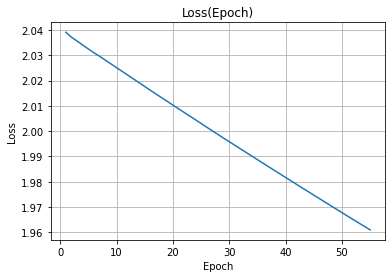

In [13]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_balanced_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_balanced.csv').drop(columns=['date'])
    X_min_u_train, X_min_u_test, y_min_u_train, y_min_u_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train':X_min_u_train.astype(float),
            'X_test': X_min_u_test.astype(float),
            'y_train':y_min_u_train.astype(float),
            'y_test': y_min_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_min_reg)
    prediction = pd.DataFrame(prediction, columns=y_min_u.columns)
    y_min_u_train = pd.DataFrame(y_min_u_train, columns=y_min_u.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_min_reg['y_test'], threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_balanced_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

[I 2022-10-15 06:23:09,342] A new study created in memory with name: no-name-a8bbf06a-0e62-47d4-ae14-e795b21378b9
[I 2022-10-15 06:23:53,284] Trial 0 finished with value: 0.09791744627332286 and parameters: {'hidden_size': 1, 'n_layers': 3, 'dropout': 0.21288003364174257, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.00017087054763193825, 'epochs': 47, 'batch_size': 2}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4424
true_negatives_ctr:  243663
false_positives_ctr:  58884
false_negatives_ctr:  525
23146920298011272112


[I 2022-10-15 06:25:04,747] Trial 1 finished with value: 0.0740877950787035 and parameters: {'hidden_size': 33, 'n_layers': 3, 'dropout': 0.4721032910031137, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 5.033844629073941e-05, 'epochs': 94, 'batch_size': 128}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4935
true_negatives_ctr:  226086
false_positives_ctr:  76461
false_negatives_ctr:  14
27555857497632466800


[I 2022-10-15 06:26:03,934] Trial 2 finished with value: 0.07717778955321965 and parameters: {'hidden_size': 17, 'n_layers': 3, 'dropout': 0.14841298505750727, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.001961295282258865, 'epochs': 84, 'batch_size': 32}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4934
true_negatives_ctr:  226104
false_positives_ctr:  76443
false_negatives_ctr:  15
27551740302390458889


[I 2022-10-15 06:26:47,157] Trial 3 finished with value: 0.07399039041074583 and parameters: {'hidden_size': 32, 'n_layers': 3, 'dropout': 0.45685331689350306, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 0.00519788511495302, 'epochs': 50, 'batch_size': 512}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4935
true_negatives_ctr:  225985
false_positives_ctr:  76562
false_negatives_ctr:  14
27577725493423186809


[I 2022-10-15 06:27:41,316] Trial 4 finished with value: 0.06461615450921095 and parameters: {'hidden_size': 37, 'n_layers': 2, 'dropout': 0.29138017450257486, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.07021756024771855, 'epochs': 94, 'batch_size': 64}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4949
true_negatives_ctr:  209124
false_positives_ctr:  93423
false_negatives_ctr:  0
30802479916095491184


[I 2022-10-15 06:28:21,227] Trial 5 finished with value: -0.04565266539940654 and parameters: {'hidden_size': 25, 'n_layers': 3, 'dropout': 0.2787193509075894, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 1.9702113833478863e-05, 'epochs': 45, 'batch_size': 64}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  1800
true_negatives_ctr:  194417
false_positives_ctr:  108130
false_negatives_ctr:  3149
32519116637124229140


[I 2022-10-15 06:29:22,717] Trial 6 finished with value: 0.07717289534919511 and parameters: {'hidden_size': 2, 'n_layers': 3, 'dropout': 0.24317704766544607, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.00014549584739486211, 'epochs': 92, 'batch_size': 1024}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4906
true_negatives_ctr:  227097
false_positives_ctr:  75450
false_negatives_ctr:  43
27328905333303569520


[I 2022-10-15 06:30:07,878] Trial 7 finished with value: 0.013901976619151995 and parameters: {'hidden_size': 58, 'n_layers': 2, 'dropout': 0.4370377547666547, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 1.531733219481562e-05, 'epochs': 58, 'batch_size': 4}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  2804
true_negatives_ctr:  205430
false_positives_ctr:  97117
false_negatives_ctr:  2145
31055757230088837225


[I 2022-10-15 06:30:54,690] Trial 8 finished with value: 0.0654811153668952 and parameters: {'hidden_size': 62, 'n_layers': 2, 'dropout': 0.47688587843512564, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.005061915803703362, 'epochs': 42, 'batch_size': 64}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4587
true_negatives_ctr:  235878
false_positives_ctr:  66669
false_negatives_ctr:  362
25204911564351496320


[I 2022-10-15 06:31:33,316] Trial 9 finished with value: 0.051625273495364395 and parameters: {'hidden_size': 98, 'n_layers': 1, 'dropout': 0.4283159206760629, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 4.387622409901597e-05, 'epochs': 45, 'batch_size': 1024}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4263
true_negatives_ctr:  185275
false_positives_ctr:  117272
false_negatives_ctr:  686
33840248454865498905


[I 2022-10-15 06:32:05,719] Trial 10 finished with value: 0.07421304248459622 and parameters: {'hidden_size': 77, 'n_layers': 1, 'dropout': 0.012121651831497576, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0004958661099400853, 'epochs': 16, 'batch_size': 2}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4935
true_negatives_ctr:  226086
false_positives_ctr:  76461
false_negatives_ctr:  14
27555857497632466800


[I 2022-10-15 06:32:58,879] Trial 11 finished with value: 0.07466865914605607 and parameters: {'hidden_size': 1, 'n_layers': 3, 'dropout': 0.1320931401829461, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.002079480398481021, 'epochs': 71, 'batch_size': 32}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4935
true_negatives_ctr:  226086
false_positives_ctr:  76461
false_negatives_ctr:  14
27555857497632466800


[I 2022-10-15 06:33:34,257] Trial 12 finished with value: 0.07415613907189816 and parameters: {'hidden_size': 15, 'n_layers': 3, 'dropout': 0.15727461857633915, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.00032779058859329043, 'epochs': 21, 'batch_size': 2}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4935
true_negatives_ctr:  226086
false_positives_ctr:  76461
false_negatives_ctr:  14
27555857497632466800


[I 2022-10-15 06:34:24,832] Trial 13 finished with value: 0.07720888415119201 and parameters: {'hidden_size': 17, 'n_layers': 2, 'dropout': 0.14709754609958764, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.05179287053507646, 'epochs': 73, 'batch_size': 1}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4727
true_negatives_ctr:  240663
false_positives_ctr:  61884
false_negatives_ctr:  222
24025144888165020705


[I 2022-10-15 06:35:13,005] Trial 14 finished with value: 0.08367209880678948 and parameters: {'hidden_size': 9, 'n_layers': 2, 'dropout': 0.04897723134761331, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.07575092332168595, 'epochs': 69, 'batch_size': 1}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4886
true_negatives_ctr:  234626
false_positives_ctr:  67921
false_negatives_ctr:  63
25584455324009223369


[I 2022-10-15 06:35:50,447] Trial 15 finished with value: 0.07145634077201636 and parameters: {'hidden_size': 45, 'n_layers': 1, 'dropout': 0.055170295140768516, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.022425000700809175, 'epochs': 30, 'batch_size': 1}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4608
true_negatives_ctr:  240301
false_positives_ctr:  62246
false_negatives_ctr:  341
24088465221729407604


[I 2022-10-15 06:36:38,091] Trial 16 finished with value: 0.07762226738948408 and parameters: {'hidden_size': 9, 'n_layers': 2, 'dropout': 0.3554071698076625, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.012791720185259967, 'epochs': 63, 'batch_size': 8}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4726
true_negatives_ctr:  234782
false_positives_ctr:  67765
false_negatives_ctr:  223
25507711597790762865


[I 2022-10-15 06:37:19,022] Trial 17 finished with value: 0.07405331429933121 and parameters: {'hidden_size': 74, 'n_layers': 2, 'dropout': 0.08228870653795378, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.0001402682732710556, 'epochs': 30, 'batch_size': 16}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4935
true_negatives_ctr:  226086
false_positives_ctr:  76461
false_negatives_ctr:  14
27555857497632466800


[I 2022-10-15 06:37:47,726] Trial 18 finished with value: 0.07549338099894684 and parameters: {'hidden_size': 26, 'n_layers': 2, 'dropout': 0.2150199444630541, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0009634301285832058, 'epochs': 1, 'batch_size': 256}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4933
true_negatives_ctr:  226155
false_positives_ctr:  76392
false_negatives_ctr:  16
27540466661046102225


[I 2022-10-15 06:38:39,559] Trial 19 finished with value: 0.07405331429933121 and parameters: {'hidden_size': 44, 'n_layers': 1, 'dropout': 0.00211998047848444, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.0001729467942000051, 'epochs': 77, 'batch_size': 2}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4935
true_negatives_ctr:  226086
false_positives_ctr:  76461
false_negatives_ctr:  14
27555857497632466800


[I 2022-10-15 06:39:26,542] Trial 20 finished with value: 0.07377654179277056 and parameters: {'hidden_size': 9, 'n_layers': 2, 'dropout': 0.3284173805651373, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.02422082512362975, 'epochs': 60, 'batch_size': 1}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4771
true_negatives_ctr:  233730
false_positives_ctr:  68817
false_negatives_ctr:  178
25772846073889376112


[I 2022-10-15 06:40:14,613] Trial 21 finished with value: 0.06636339546489702 and parameters: {'hidden_size': 13, 'n_layers': 2, 'dropout': 0.36464184804384214, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.01702018781782053, 'epochs': 63, 'batch_size': 8}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4424
true_negatives_ctr:  241793
false_positives_ctr:  60754
false_negatives_ctr:  525
23648141234743888212


[I 2022-10-15 06:41:03,081] Trial 22 finished with value: 0.06829324995167288 and parameters: {'hidden_size': 7, 'n_layers': 2, 'dropout': 0.37655123303194143, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.009615071485505004, 'epochs': 65, 'batch_size': 8}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4732
true_negatives_ctr:  228308
false_positives_ctr:  74239
false_negatives_ctr:  217
27021637266571695825


[I 2022-10-15 06:41:59,455] Trial 23 finished with value: 0.07387883892442158 and parameters: {'hidden_size': 24, 'n_layers': 2, 'dropout': 0.19928181746816057, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.061969581126864674, 'epochs': 83, 'batch_size': 8}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4726
true_negatives_ctr:  234921
false_positives_ctr:  67626
false_negatives_ctr:  223
25473859375589124864


[I 2022-10-15 06:42:40,447] Trial 24 finished with value: 0.07405331429933121 and parameters: {'hidden_size': 1, 'n_layers': 1, 'dropout': 0.3742177624257702, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.09742536726849528, 'epochs': 56, 'batch_size': 16}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4935
true_negatives_ctr:  226086
false_positives_ctr:  76461
false_negatives_ctr:  14
27555857497632466800


[I 2022-10-15 06:43:19,347] Trial 25 finished with value: 0.08206265111105282 and parameters: {'hidden_size': 8, 'n_layers': 2, 'dropout': 0.08726415349927041, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.03641811715977326, 'epochs': 36, 'batch_size': 256}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4869
true_negatives_ctr:  233617
false_positives_ctr:  68930
false_negatives_ctr:  80
25823429530686720009


[I 2022-10-15 06:43:55,337] Trial 26 finished with value: 0.06865192930133432 and parameters: {'hidden_size': 20, 'n_layers': 2, 'dropout': 0.08414224389138118, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.047753495516972194, 'epochs': 33, 'batch_size': 256}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4948
true_negatives_ctr:  217050
false_positives_ctr:  85497
false_negatives_ctr:  1
29393862540623277585


[I 2022-10-15 06:44:37,241] Trial 27 finished with value: 0.074053522202168 and parameters: {'hidden_size': 7, 'n_layers': 3, 'dropout': 0.06258545831633956, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.005796935702965601, 'epochs': 37, 'batch_size': 256}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4935
true_negatives_ctr:  226086
false_positives_ctr:  76461
false_negatives_ctr:  14
27555857497632466800


[I 2022-10-15 06:45:14,059] Trial 28 finished with value: 0.07200489802689576 and parameters: {'hidden_size': 30, 'n_layers': 2, 'dropout': 0.19382393920056692, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.033756140957833344, 'epochs': 21, 'batch_size': 512}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4780
true_negatives_ctr:  232692
false_positives_ctr:  69855
false_negatives_ctr:  169
26022534922515990705


[I 2022-10-15 06:46:04,967] Trial 29 finished with value: 0.07447353748216125 and parameters: {'hidden_size': 38, 'n_layers': 3, 'dropout': 0.11820521301127035, 'activation': 'relu', 'optimizer': 'adam', 'lr': 3.98675688126378e-05, 'epochs': 48, 'batch_size': 128}. Best is trial 0 with value: 0.09791744627332286.


true_positives_ctr:  4935
true_negatives_ctr:  226086
false_positives_ctr:  76461
false_negatives_ctr:  14
27555857497632466800
Number of finished trials:  30
Best trial:
  Value: 0.09791744627332286
  Params: 
    hidden_size: 1
    n_layers: 3
    dropout: 0.21288003364174257
    activation: relu
    optimizer: adam
    lr: 0.00017087054763193825
    epochs: 47
    batch_size: 2


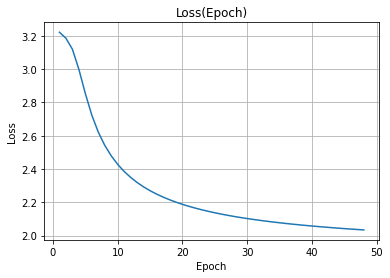

In [14]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv').drop(columns=['date'])
    X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train':X_max_u_train.astype(float),
            'X_test': X_max_u_test.astype(float),
            'y_train':y_max_u_train.astype(float),
            'y_test': y_max_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_max_reg)
    prediction = pd.DataFrame(prediction, columns=y_max_u.columns)
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_max_reg['y_test'], threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_balanced_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

In [15]:
import beepy
beepy.beep(6)